# Predicción de indice contaminante

In [2]:
# Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm


In [3]:
# Importar datos
indice_contaminacion = pd.read_csv(r'./CSV/indice_contaminacion.csv')
solicitud_locatel = pd.read_csv(r"./CSV/Solicitud_Locatel.csv")
tiempo = pd.read_csv(r"./CSV/Tiempo.csv")
zona = pd.read_csv(r"./CSV/Zona.csv")
tipo_contaminante = pd.read_csv(r"./CSV/Tipo Contaminante.csv")

In [4]:
# Observar datos
indice_contaminacion.head()


,idContaminacion,indiceContaminante,idTipoContaminante,idZona,idTiempo,esNulo
0,0,NaN,36,0,0,1
1,1,5.0,1,0,0,0
2,2,NaN,38,0,0,1
3,3,10.0,15,0,0,0
4,4,64.0,22,0,0,0


In [5]:
solicitud_locatel

,idSolicitud,tipoEntrada,estatusSolicitud,sexo,edad,idZona,idTiempo
0,0,USUARIOS SUAC DEPENDENCIA,ATENDIDO,MASCULINO,NaN,2,4623
1,1,PORTAL CIUDADANO SUAC,ATENDIDO,FEMENINO,NaN,3,3683
2,2,PORTAL CIUDADANO SUAC,ATENDIDO,FEMENINO,60.0,3,3683
3,3,OPERADOR TELEFÓNICO LOCATEL,ATENDIDO,FEMENINO,23.0,1,3683
4,4,PORTAL CIUDADANO SUAC,ATENDIDO,NO ESPECIFICADO,NaN,3,3683
...,...,...,...,...,...,...,...
82016,82016,PORTAL CIUDADANO SUAC,CERRADO,NaN,NaN,0,31650
82017,82017,PORTAL CIUDADANO SUAC,CERRADO,NaN,NaN,0,31651
82018,82018,PORTAL CIUDADANO SUAC,TURNADO,NaN,NaN,0,31739
82019,82019,PORTAL CIUDADANO SUAC,TURNADO,NaN,NaN,1,31793


In [6]:
tiempo.head()

,idTiempo,año,semestre,trimestre,bimestre,mes,dia,hora,esFestivo
0,0,2019,1,1,1,1,1,0,1
1,1,2019,1,1,1,1,1,1,1
2,2,2019,1,1,1,1,1,2,1
3,3,2019,1,1,1,1,1,3,1
4,4,2019,1,1,1,1,1,4,1


In [7]:
tipo_contaminante.head()

,idTipoContaminante,nombreContaminante,tipoPeligrosidad
0,0,ozono,0
1,1,dióxido de azufre,0
2,2,dióxido de nitrógeno,0
3,3,monóxido de carbono,0
4,4,PM10,0


In [8]:
# Reemplazar idZona con nombre de zona desde dataframe Zona
# Hacer diccionario con idZona y nombre de zona
zona_dict = dict(zip(zona.idZona, zona.zonaCDMX))
zona_dict

# Reemplazar idZona con nombre de zona
indice_contaminacion['nombreZona'] = indice_contaminacion['idZona'].map(zona_dict)
indice_contaminacion

# Hacer diccionario con tiempo idTiempo,año,semestre,trimestre,bimestre,mes,dia,hora,esFestivo
tiempo_dict_anio = dict(zip(tiempo.idTiempo, tiempo.año))
tiempo_dict_mes = dict(zip(tiempo.idTiempo, tiempo.mes))
tiempo_dict_dia = dict(zip(tiempo.idTiempo, tiempo.dia))

# Reemplazar idTiempo con año
indice_contaminacion['año'] = indice_contaminacion['idTiempo'].map(tiempo_dict_anio)
indice_contaminacion['mes'] = indice_contaminacion['idTiempo'].map(tiempo_dict_mes)
indice_contaminacion['dia'] = indice_contaminacion['idTiempo'].map(tiempo_dict_dia)

# Juntar dia, mes y año en una sola columna y eliminar las otras 3
indice_contaminacion['fecha'] = indice_contaminacion['dia'].astype(str) + '-' + indice_contaminacion['mes'].astype(str) + '-' + indice_contaminacion['año'].astype(str)

# Convertir fecha a datetime
indice_contaminacion['fecha'] = pd.to_datetime(indice_contaminacion['fecha'], format='%d-%m-%Y')
indice_contaminacion = indice_contaminacion.drop(['dia', 'mes', 'año'], axis=1)


# Reemplazar idTipoContaminante con nombre de tipo de contaminante desde dataframe Tipo Contaminante idTipoContaminante,nombreContaminante,tipoPeligrosidad
# Hacer diccionario con idTipoContaminante y nombre de tipo de contaminante
tipo_contaminante_dict = dict(zip(tipo_contaminante.idTipoContaminante, tipo_contaminante.nombreContaminante))

# Reemplazar idTipoContaminante con nombre de tipo de contaminante
indice_contaminacion['tipoContaminante'] = indice_contaminacion['idTipoContaminante'].map(tipo_contaminante_dict)


# Revisar nulos
indice_contaminacion.isnull().sum()

idContaminacion           0
indiceContaminante    17558
idTipoContaminante        0
idZona                    0
idTiempo                  0
esNulo                    0
nombreZona                0
fecha                     0
tipoContaminante          0
dtype: int64

In [9]:
# Revisar que tipoContaminante y zona tiene mas nulos
indice_contaminacion


,idContaminacion,indiceContaminante,idTipoContaminante,idZona,idTiempo,esNulo,nombreZona,fecha,tipoContaminante
0,0,NaN,36,0,0,1,Noroeste,2019-01-01,ozono
1,1,5.0,1,0,0,0,Noroeste,2019-01-01,dióxido de azufre
2,2,NaN,38,0,0,1,Noroeste,2019-01-01,dióxido de nitrógeno
3,3,10.0,15,0,0,0,Noroeste,2019-01-01,monóxido de carbono
4,4,64.0,22,0,0,0,Noroeste,2019-01-01,PM10
...,...,...,...,...,...,...,...,...,...
964075,964075,4.0,1,4,32135,0,Sureste,2022-08-31,dióxido de azufre
964076,964076,13.0,2,4,32135,0,Sureste,2022-08-31,dióxido de nitrógeno
964077,964077,4.0,3,4,32135,0,Sureste,2022-08-31,monóxido de carbono
964078,964078,30.0,10,4,32135,0,Sureste,2022-08-31,PM10


In [10]:
indice_contaminacion['indiceContaminante_nulos'] = indice_contaminacion['indiceContaminante'].isna()

In [11]:
tipoContaminante_nulos = indice_contaminacion.groupby('tipoContaminante').sum()['indiceContaminante_nulos']
nombreZona_nulos = indice_contaminacion.groupby('nombreZona').sum()['indiceContaminante_nulos']
nulos_por_tipo_y_zona = indice_contaminacion.groupby(['tipoContaminante', 'nombreZona']).sum()['indiceContaminante_nulos']

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\501219072.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tipoContaminante_nulos = indice_contaminacion.groupby('tipoContaminante').sum()['indiceContaminante_nulos']
C:\Users\josev\AppData\Local\Temp\ipykernel_23448\501219072.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nombreZona_nulos = indice_contaminacion.groupby('nombreZona').sum()['indiceContaminante_nulos']
C:\Users\josev\AppData\Local\Temp\ipykernel_23448\501219072.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only 

In [12]:

print("Tipo de contaminante y zona con más nulos: ", nulos_por_tipo_y_zona)

Tipo de contaminante y zona con más nulos:  tipoContaminante      nombreZona
PM10                  Centro           5
                      Noreste        161
                      Noroeste        73
                      Sureste        907
                      Suroeste       201
PM25                  Centro         260
                      Noreste        225
                      Noroeste      1738
                      Sureste         82
                      Suroeste       189
dióxido de azufre     Centro           1
                      Noreste          0
                      Noroeste         1
                      Sureste         16
                      Suroeste         1
dióxido de nitrógeno  Centro         704
                      Noreste        728
                      Noroeste       744
                      Sureste        755
                      Suroeste       735
monóxido de carbono   Centro        1195
                      Noreste       1226
                     

In [13]:
# Promedio de indice por cada tipo de contaminante
indice_contaminacion.groupby('tipoContaminante').mean()['indiceContaminante']

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1576927866.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  indice_contaminacion.groupby('tipoContaminante').mean()['indiceContaminante']


tipoContaminante
PM10                    58.397928
PM25                    65.400193
dióxido de azufre        8.169201
dióxido de nitrógeno    13.260340
monóxido de carbono      4.745366
ozono                   30.156003
Name: indiceContaminante, dtype: float64

In [14]:
# Interpolar nulos por tipo de contaminante y zona
indice_contaminacion['indiceContaminante'] = indice_contaminacion.groupby(['tipoContaminante', 'nombreZona'])['indiceContaminante'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

In [15]:
# Promedio de indice por cada tipo de contaminante
indice_contaminacion.groupby('tipoContaminante').mean()['indiceContaminante']

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1576927866.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  indice_contaminacion.groupby('tipoContaminante').mean()['indiceContaminante']


tipoContaminante
PM10                    58.233333
PM25                    65.258508
dióxido de azufre        8.169399
dióxido de nitrógeno    13.255887
monóxido de carbono      4.765686
ozono                   29.846440
Name: indiceContaminante, dtype: float64

In [16]:
# Revisar nulos
indice_contaminacion.isnull().sum()

# iniciar el dataframe desde 2019-01-01, recortar los datos anteriores
indice_contaminacion = indice_contaminacion[indice_contaminacion['fecha'] >= '2019-01-01']
indice_contaminacion

,idContaminacion,indiceContaminante,idTipoContaminante,idZona,idTiempo,esNulo,nombreZona,fecha,tipoContaminante,indiceContaminante_nulos
0,0,6.0,36,0,0,1,Noroeste,2019-01-01,ozono,True
1,1,5.0,1,0,0,0,Noroeste,2019-01-01,dióxido de azufre,False
2,2,17.0,38,0,0,1,Noroeste,2019-01-01,dióxido de nitrógeno,True
3,3,10.0,15,0,0,0,Noroeste,2019-01-01,monóxido de carbono,False
4,4,64.0,22,0,0,0,Noroeste,2019-01-01,PM10,False
...,...,...,...,...,...,...,...,...,...,...
964075,964075,4.0,1,4,32135,0,Sureste,2022-08-31,dióxido de azufre,False
964076,964076,13.0,2,4,32135,0,Sureste,2022-08-31,dióxido de nitrógeno,False
964077,964077,4.0,3,4,32135,0,Sureste,2022-08-31,monóxido de carbono,False
964078,964078,30.0,10,4,32135,0,Sureste,2022-08-31,PM10,False


In [17]:
# En Solicitud_Locatel reemplazar idZona,idTiempo con nombre de zona y año
# Hacer diccionario con idZona y nombre de zona
zona_dict = dict(zip(zona.idZona, zona.zonaCDMX))

# Reemplazar idZona con nombre de zona
solicitud_locatel['nombreZona'] = solicitud_locatel['idZona'].map(zona_dict)

# Hacer diccionario con tiempo idTiempo,año,semestre,trimestre,bimestre,mes,dia,hora,esFestivo
tiempo_dict_anio = dict(zip(tiempo.idTiempo, tiempo.año))
tiempo_dict_mes = dict(zip(tiempo.idTiempo, tiempo.mes))
tiempo_dict_dia = dict(zip(tiempo.idTiempo, tiempo.dia))

# Reemplazar idTiempo con año
solicitud_locatel['año'] = solicitud_locatel['idTiempo'].map(tiempo_dict_anio)
solicitud_locatel['mes'] = solicitud_locatel['idTiempo'].map(tiempo_dict_mes)
solicitud_locatel['dia'] = solicitud_locatel['idTiempo'].map(tiempo_dict_dia)

# Juntar dia, mes y año en una sola columna y eliminar las otras 3
solicitud_locatel['fecha'] = solicitud_locatel['dia'].astype(str) + '/' + solicitud_locatel['mes'].astype(str) + '/' + solicitud_locatel['año'].astype(str)
solicitud_locatel = solicitud_locatel.drop(['dia', 'mes', 'año'], axis=1)

# Convertir fecha a datetime
solicitud_locatel['fecha'] = pd.to_datetime(solicitud_locatel['fecha'], format='%d/%m/%Y')

# Interpolar los nulos de edad
solicitud_locatel['edad'] = solicitud_locatel['edad'].interpolate(method='linear', limit_direction='both')

# Revisar nulos
solicitud_locatel.isnull().sum()

# Cambiar nulls de sexo por 'No especificado'
solicitud_locatel['sexo'] = solicitud_locatel['sexo'].fillna('No especificado')



In [18]:
# Revisar nulos
print("Los nulos para locatel son:", solicitud_locatel.isnull().sum())
print("Los nulos para indice contaminacion son:", indice_contaminacion.isnull().sum())

Los nulos para locatel son: idSolicitud         0
tipoEntrada         0
estatusSolicitud    0
sexo                0
edad                0
idZona              0
idTiempo            0
nombreZona          0
fecha               0
dtype: int64
Los nulos para indice contaminacion son: idContaminacion             0
indiceContaminante          0
idTipoContaminante          0
idZona                      0
idTiempo                    0
esNulo                      0
nombreZona                  0
fecha                       0
tipoContaminante            0
indiceContaminante_nulos    0
dtype: int64


In [19]:
# Unir los datasets en base a idZona y idTiempo

merged_data = pd.merge(solicitud_locatel, indice_contaminacion, on=['idZona', 'idTiempo'],suffixes=('', '_y'))


print(merged_data)

        idSolicitud                tipoEntrada estatusSolicitud  \
0                 0  USUARIOS SUAC DEPENDENCIA         ATENDIDO   
1                 0  USUARIOS SUAC DEPENDENCIA         ATENDIDO   
2                 0  USUARIOS SUAC DEPENDENCIA         ATENDIDO   
3                 0  USUARIOS SUAC DEPENDENCIA         ATENDIDO   
4                 0  USUARIOS SUAC DEPENDENCIA         ATENDIDO   
...             ...                        ...              ...   
492121        82004      PORTAL CIUDADANO SUAC          CERRADO   
492122        82004      PORTAL CIUDADANO SUAC          CERRADO   
492123        82004      PORTAL CIUDADANO SUAC          CERRADO   
492124        82004      PORTAL CIUDADANO SUAC          CERRADO   
492125        82004      PORTAL CIUDADANO SUAC          CERRADO   

                   sexo  edad  idZona  idTiempo nombreZona      fecha  \
0             MASCULINO  60.0       2      4623     Centro 2019-07-12   
1             MASCULINO  60.0       2      4623  

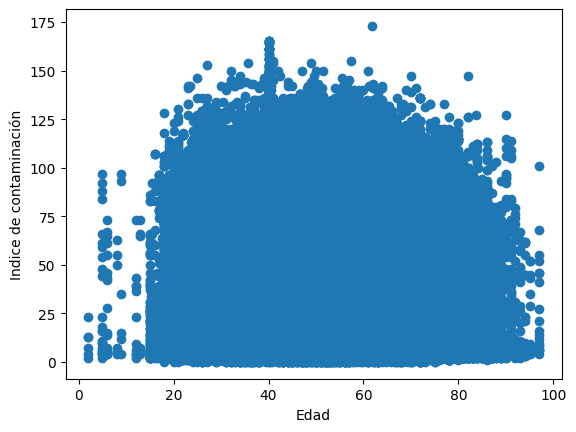

In [20]:
# Gráfico de dispersión
plt.scatter(merged_data['edad'], merged_data['indiceContaminante'])
plt.xlabel('Edad')
plt.ylabel('Indice de contaminación')
plt.show()

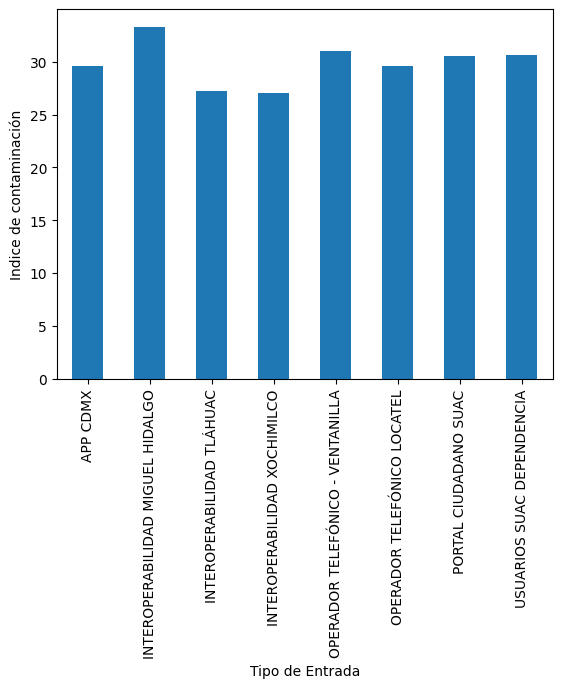

In [21]:
# Gráfico de barras
merged_data.groupby(['tipoEntrada'])['indiceContaminante'].mean().plot(kind='bar')
plt.xlabel('Tipo de Entrada')
plt.ylabel('Indice de contaminación')
plt.show()

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\3021531775.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_data.corr()


                          idSolicitud      edad    idZona  idTiempo  \
idSolicitud                  1.000000 -0.284686  0.068621  0.990295   
edad                        -0.284686  1.000000 -0.028027 -0.288313   
idZona                       0.068621 -0.028027  1.000000  0.051477   
idTiempo                     0.990295 -0.288313  0.051477  1.000000   
idContaminacion              0.990295 -0.288313  0.051507  1.000000   
indiceContaminante          -0.016542 -0.004049 -0.067909 -0.007685   
idTipoContaminante          -0.009933 -0.002606 -0.040671 -0.006321   
esNulo                      -0.011122  0.003688 -0.023511 -0.013019   
indiceContaminante_nulos    -0.011122  0.003688 -0.023511 -0.013019   

                          idContaminacion  indiceContaminante  \
idSolicitud                      0.990295           -0.016542   
edad                            -0.288313           -0.004049   
idZona                           0.051507           -0.067909   
idTiempo                     

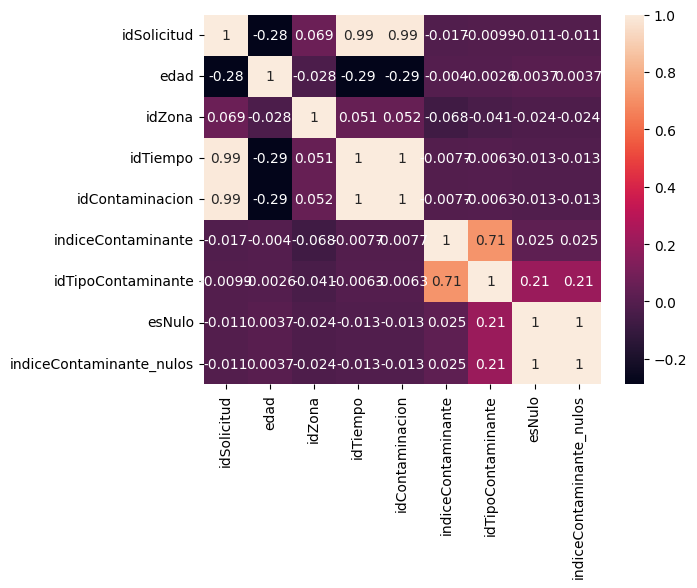

In [22]:
correlation_matrix = merged_data.corr()
print(correlation_matrix)

# Graficarlo
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# Forecasting con SARIMA

In [23]:
# Importamos librerias necesarias para SARIMA
# Librerias base
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

# Librerias de statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import pmdarima as pm
from pmdarima import model_selection
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import math

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import datetime as dt

<AxesSubplot: >

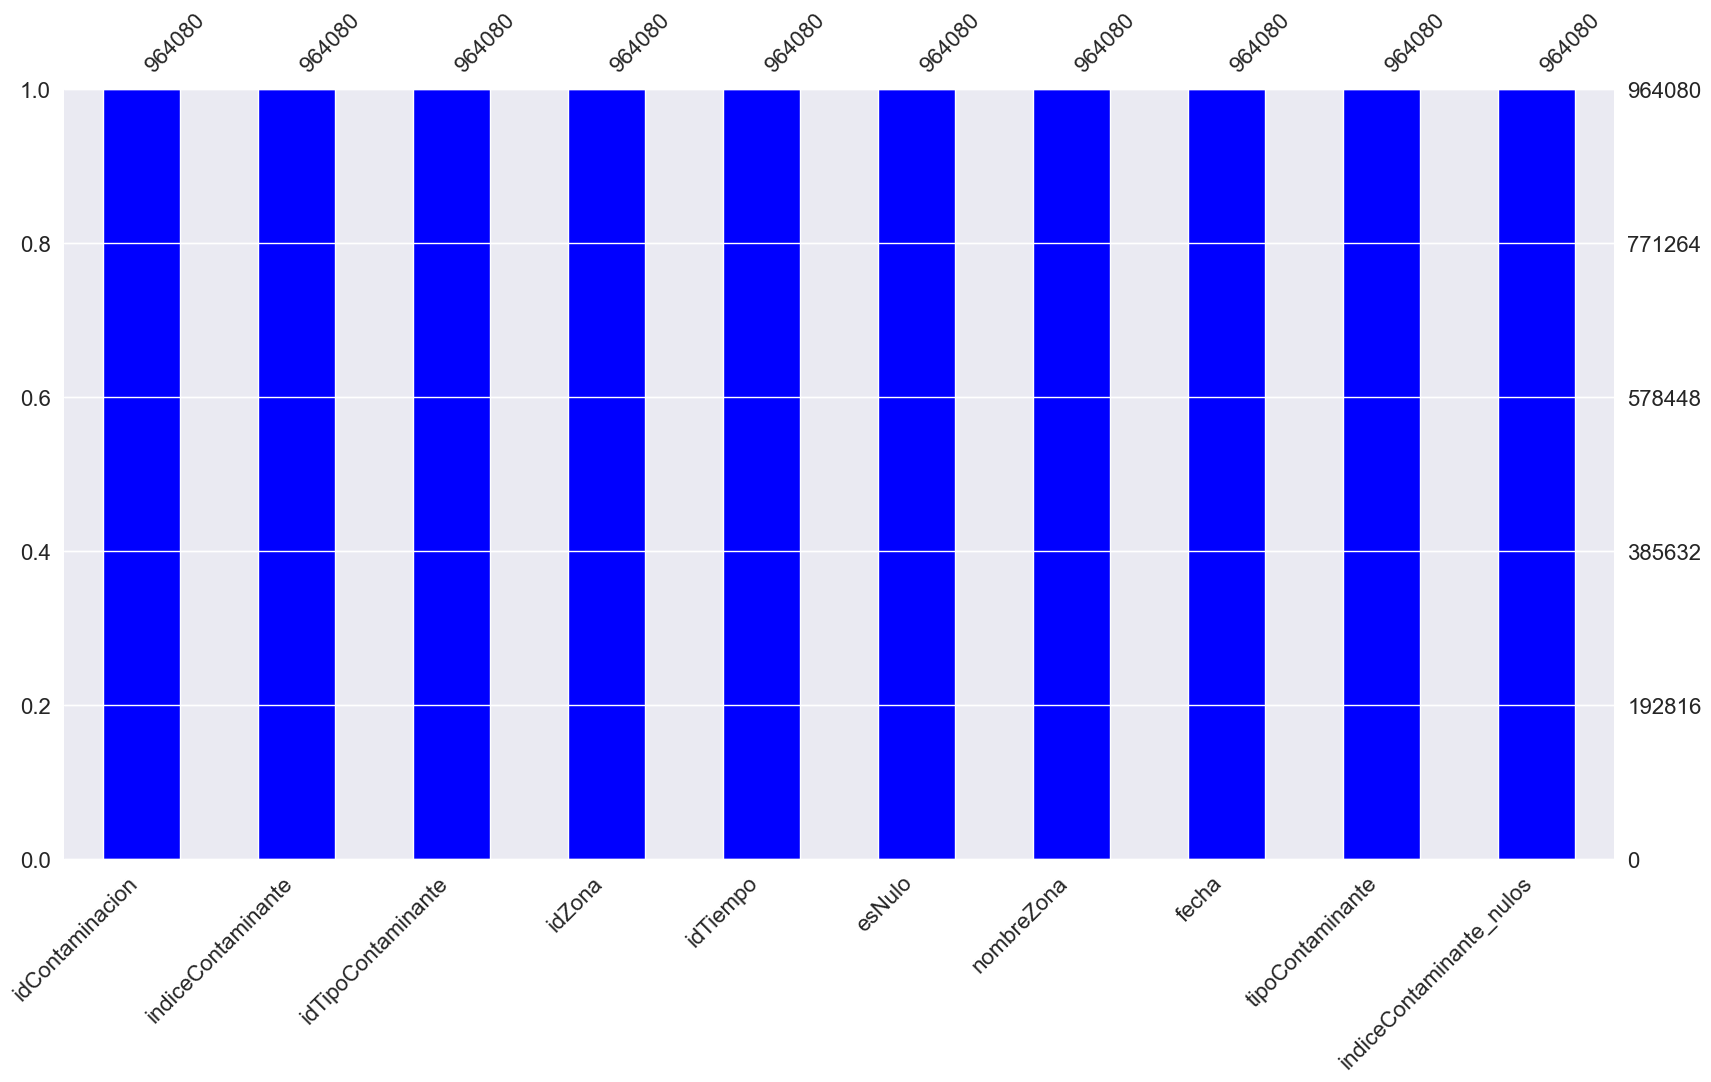

In [24]:
# Comprobamos, una vez mas si no hay nulos en el dataset
msno.bar(indice_contaminacion, figsize=(20, 10), color=('blue'))

In [25]:
indice_contaminacion.describe().style.background_gradient(cmap='Blues')

,idContaminacion,indiceContaminante,idTipoContaminante,idZona,idTiempo,esNulo
count,964080.000000,964080.000000,964080.000000,964080.000000,964080.000000,964080.000000
mean,482039.500000,29.921542,10.199795,2.000000,16067.500000,0.018212
std,278306.068098,29.505083,11.826459,1.414214,9276.868932,0.133718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,241019.750000,6.000000,1.000000,1.000000,8033.750000,0.000000
50%,482039.500000,16.000000,3.000000,2.000000,16067.500000,0.000000
75%,723059.250000,52.000000,22.000000,3.000000,24101.250000,0.000000
max,964079.000000,185.000000,41.000000,4.000000,32135.000000,1.000000


In [26]:
## Verificamos los tipos de datos

indice_contaminacion.dtypes

idContaminacion                      int64
indiceContaminante                 float64
idTipoContaminante                   int64
idZona                               int64
idTiempo                             int64
esNulo                               int64
nombreZona                          object
fecha                       datetime64[ns]
tipoContaminante                    object
indiceContaminante_nulos              bool
dtype: object

In [27]:
## Verificamos las Zonas y los tipos de contaminantes
contaminantes = indice_contaminacion['tipoContaminante'].unique()
zonas = indice_contaminacion['nombreZona'].unique()

In [28]:
print("Los contaminantes son:", contaminantes)
print("Las zonas son:", zonas)

Los contaminantes son: ['ozono' 'dióxido de azufre' 'dióxido de nitrógeno' 'monóxido de carbono'
 'PM10' 'PM25']
Las zonas son: ['Noroeste' 'Noreste' 'Centro' 'Suroeste' 'Sureste']


In [29]:
# Cantidad de datos por contaminante
print("La cantidad de indices de contaminacion son", indice_contaminacion.groupby('tipoContaminante').count()['indiceContaminante'])

# Cantidad de datos por zona
print("La cantidad de datos por zona son", indice_contaminacion.groupby('nombreZona').count()['indiceContaminante'])

indice_contaminacion

La cantidad de indices de contaminacion son tipoContaminante
PM10                    160680
PM25                    160680
dióxido de azufre       160680
dióxido de nitrógeno    160680
monóxido de carbono     160680
ozono                   160680
Name: indiceContaminante, dtype: int64
La cantidad de datos por zona son nombreZona
Centro      192816
Noreste     192816
Noroeste    192816
Sureste     192816
Suroeste    192816
Name: indiceContaminante, dtype: int64


,idContaminacion,indiceContaminante,idTipoContaminante,idZona,idTiempo,esNulo,nombreZona,fecha,tipoContaminante,indiceContaminante_nulos
0,0,6.0,36,0,0,1,Noroeste,2019-01-01,ozono,True
1,1,5.0,1,0,0,0,Noroeste,2019-01-01,dióxido de azufre,False
2,2,17.0,38,0,0,1,Noroeste,2019-01-01,dióxido de nitrógeno,True
3,3,10.0,15,0,0,0,Noroeste,2019-01-01,monóxido de carbono,False
4,4,64.0,22,0,0,0,Noroeste,2019-01-01,PM10,False
...,...,...,...,...,...,...,...,...,...,...
964075,964075,4.0,1,4,32135,0,Sureste,2022-08-31,dióxido de azufre,False
964076,964076,13.0,2,4,32135,0,Sureste,2022-08-31,dióxido de nitrógeno,False
964077,964077,4.0,3,4,32135,0,Sureste,2022-08-31,monóxido de carbono,False
964078,964078,30.0,10,4,32135,0,Sureste,2022-08-31,PM10,False


In [30]:
# Agrupar por fecha, tipoContaminante, y nombreZona y promediar el indiceContaminante

indice_contaminacion = indice_contaminacion.groupby(['fecha', 'tipoContaminante', 'nombreZona']).mean().reset_index()

# Primeros 10
indice_contaminacion.head(10)

,fecha,tipoContaminante,nombreZona,idContaminacion,indiceContaminante,idTipoContaminante,idZona,idTiempo,esNulo,indiceContaminante_nulos
0,2019-01-01,PM10,Centro,361.0,103.666667,26.75,2.0,11.5,0.0,0.0
1,2019-01-01,PM10,Noreste,355.0,148.125000,31.75,1.0,11.5,0.0,0.0
2,2019-01-01,PM10,Noroeste,349.0,105.791667,27.00,0.0,11.5,0.0,0.0
3,2019-01-01,PM10,Sureste,373.0,108.291667,27.00,4.0,11.5,0.0,0.0
4,2019-01-01,PM10,Suroeste,367.0,85.166667,22.25,3.0,11.5,0.0,0.0
5,2019-01-01,PM25,Centro,362.0,114.541667,34.50,2.0,11.5,0.0,0.0
6,2019-01-01,PM25,Noreste,356.0,155.500000,34.75,1.0,11.5,0.0,0.0
7,2019-01-01,PM25,Noroeste,350.0,114.625000,34.75,0.0,11.5,0.0,0.0
8,2019-01-01,PM25,Sureste,374.0,124.583333,34.50,4.0,11.5,0.0,0.0
9,2019-01-01,PM25,Suroeste,368.0,94.333333,34.00,3.0,11.5,0.0,0.0


In [77]:
# Aislamiento de los datos de cada contaminante

# PM10
pm10 = indice_contaminacion[indice_contaminacion['tipoContaminante'] == 'PM10']

# PM25
pm25 = indice_contaminacion[indice_contaminacion['tipoContaminante'] == 'PM25']

# Centro
pm10_centro = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM10') & (indice_contaminacion['nombreZona'] == 'Centro')]
pm25_centro = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM25') & (indice_contaminacion['nombreZona'] == 'Centro')]
dioazureo_centro = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de azufre') & (indice_contaminacion['nombreZona'] == 'Centro')]
dioxnitro_centro = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Centro')]
monoxnitro_centro = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'monóxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Centro')]
ozono_centro = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'ozono') & (indice_contaminacion['nombreZona'] == 'Centro')]

# Noreste
pm10_noreste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM10') & (indice_contaminacion['nombreZona'] == 'Noreste')]
pm25_noreste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM25') & (indice_contaminacion['nombreZona'] == 'Noreste')]
dioazureo_noreste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de azufre') & (indice_contaminacion['nombreZona'] == 'Noreste')]
dioxnitro_noreste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Noreste')]
monoxnitro_noreste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'monóxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Noreste')]
ozono_noreste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'ozono') & (indice_contaminacion['nombreZona'] == 'Noreste')]

# Noroeste
pm10_noroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM10') & (indice_contaminacion['nombreZona'] == 'Noroeste')]
pm25_noroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM25') & (indice_contaminacion['nombreZona'] == 'Noroeste')]
dioazureo_noroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de azufre') & (indice_contaminacion['nombreZona'] == 'Noroeste')]
dioxnitro_noroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Noroeste')]
monoxnitro_noroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'monóxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Noroeste')]
ozono_noroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'ozono') & (indice_contaminacion['nombreZona'] == 'Noroeste')]

# Sureste
pm10_sureste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM10') & (indice_contaminacion['nombreZona'] == 'Sureste')]
pm25_sureste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM25') & (indice_contaminacion['nombreZona'] == 'Sureste')]
dioazureo_sureste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de azufre') & (indice_contaminacion['nombreZona'] == 'Sureste')]
dioxnitro_sureste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Sureste')]
monoxnitro_sureste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'monóxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Sureste')]
ozono_sureste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'ozono') & (indice_contaminacion['nombreZona'] == 'Sureste')]

# Suroeste
pm10_suroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM10') & (indice_contaminacion['nombreZona'] == 'Suroeste')]
pm25_suroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'PM25') & (indice_contaminacion['nombreZona'] == 'Suroeste')]
dioazureo_suroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de azufre') & (indice_contaminacion['nombreZona'] == 'Suroeste')]
dioxnitro_suroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'dióxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Suroeste')]
monoxnitro_suroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'monóxido de nitrógeno') & (indice_contaminacion['nombreZona'] == 'Suroeste')]
ozono_suroeste = indice_contaminacion[(indice_contaminacion['tipoContaminante'] == 'ozono') & (indice_contaminacion['nombreZona'] == 'Suroeste')]


In [32]:
# Verificamos que los datos se hayan cargado correctamente
pm10_centro

,fecha,tipoContaminante,nombreZona,idContaminacion,indiceContaminante,idTipoContaminante,idZona,idTiempo,esNulo,indiceContaminante_nulos
0,2019-01-01,PM10,Centro,361.0,103.666667,26.75,2.0,11.5,0.0,0.0
30,2019-01-02,PM10,Centro,1081.0,107.125000,28.00,2.0,35.5,0.0,0.0
60,2019-01-03,PM10,Centro,1801.0,99.666667,24.50,2.0,59.5,0.0,0.0
90,2019-01-04,PM10,Centro,2521.0,95.875000,22.75,2.0,83.5,0.0,0.0
120,2019-01-05,PM10,Centro,3241.0,98.666667,25.00,2.0,107.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
40020,2022-08-27,PM10,Centro,960841.0,45.041667,16.00,2.0,32027.5,0.0,0.0
40050,2022-08-28,PM10,Centro,961561.0,41.083333,14.00,2.0,32051.5,0.0,0.0
40080,2022-08-29,PM10,Centro,962281.0,33.958333,10.00,2.0,32075.5,0.0,0.0
40110,2022-08-30,PM10,Centro,963001.0,30.041667,10.00,2.0,32099.5,0.0,0.0


In [33]:
# Definiendo indices

# Centro
pd.to_datetime(pm10_centro['fecha'], format='%Y-%m-%d')
pm10_centro.set_index('fecha', inplace=True)
pm10_centro.index = pd.to_datetime(pm10_centro.index)

pd.to_datetime(pm25_centro['fecha'], format='%Y-%m-%d')
pm25_centro .set_index('fecha', inplace=True)
pm25_centro .index = pd.to_datetime(pm25_centro .index)

pd.to_datetime(dioazureo_centro['fecha'], format='%Y-%m-%d')
dioazureo_centro.set_index('fecha', inplace=True)
dioazureo_centro.index = pd.to_datetime(dioazureo_centro.index)

pd.to_datetime(dioxnitro_centro['fecha'], format='%Y-%m-%d')
dioxnitro_centro.set_index('fecha', inplace=True)
dioxnitro_centro.index = pd.to_datetime(dioxnitro_centro.index)

pd.to_datetime(monoxnitro_centro['fecha'], format='%Y-%m-%d')
monoxnitro_centro.set_index('fecha', inplace=True)
monoxnitro_centro.index = pd.to_datetime(monoxnitro_centro.index)

pd.to_datetime(ozono_centro['fecha'], format='%Y-%m-%d')
ozono_centro.set_index('fecha', inplace=True)
ozono_centro.index = pd.to_datetime(ozono_centro.index)

# Noreste
pd.to_datetime(pm10_noreste['fecha'], format='%Y-%m-%d')
pm10_noreste.set_index('fecha', inplace=True)
pm10_noreste.index = pd.to_datetime(pm10_noreste.index)

pd.to_datetime(pm25_noreste['fecha'], format='%Y-%m-%d')
pm25_noreste.set_index('fecha', inplace=True)
pm25_noreste.index = pd.to_datetime(pm25_noreste.index)

pd.to_datetime(dioazureo_noreste['fecha'], format='%Y-%m-%d')
dioazureo_noreste.set_index('fecha', inplace=True)
dioazureo_noreste.index = pd.to_datetime(dioazureo_noreste.index)

pd.to_datetime(dioxnitro_noreste['fecha'], format='%Y-%m-%d')
dioxnitro_noreste.set_index('fecha', inplace=True)
dioxnitro_noreste.index = pd.to_datetime(dioxnitro_noreste.index)

pd.to_datetime(monoxnitro_noreste['fecha'], format='%Y-%m-%d')
monoxnitro_noreste.set_index('fecha', inplace=True)
monoxnitro_noreste.index = pd.to_datetime(monoxnitro_noreste.index)

pd.to_datetime(ozono_noreste['fecha'], format='%Y-%m-%d')
ozono_noreste.set_index('fecha', inplace=True)
ozono_noreste.index = pd.to_datetime(ozono_noreste.index)

# Noroeste
pd.to_datetime(pm10_noroeste['fecha'], format='%Y-%m-%d')
pm10_noroeste.set_index('fecha', inplace=True)
pm10_noroeste.index = pd.to_datetime(pm10_noroeste.index)

pd.to_datetime(pm25_noroeste['fecha'], format='%Y-%m-%d')
pm25_noroeste.set_index('fecha', inplace=True)
pm25_noroeste.index = pd.to_datetime(pm25_noroeste.index)

pd.to_datetime(dioazureo_noroeste['fecha'], format='%Y-%m-%d')
dioazureo_noroeste.set_index('fecha', inplace=True)
dioazureo_noroeste.index = pd.to_datetime(dioazureo_noroeste.index)

pd.to_datetime(dioxnitro_noroeste['fecha'], format='%Y-%m-%d')
dioxnitro_noroeste.set_index('fecha', inplace=True)
dioxnitro_noroeste.index = pd.to_datetime(dioxnitro_noroeste.index)

pd.to_datetime(monoxnitro_noroeste['fecha'], format='%Y-%m-%d')
monoxnitro_noroeste.set_index('fecha', inplace=True)
monoxnitro_noroeste.index = pd.to_datetime(monoxnitro_noroeste.index)

pd.to_datetime(ozono_noroeste['fecha'], format='%Y-%m-%d')
ozono_noroeste.set_index('fecha', inplace=True)
ozono_noroeste.index = pd.to_datetime(ozono_noroeste.index)

# Sureste
pd.to_datetime(pm10_sureste['fecha'], format='%Y-%m-%d')
pm10_sureste.set_index('fecha', inplace=True)
pm10_sureste.index = pd.to_datetime(pm10_sureste.index)

pd.to_datetime(pm25_sureste['fecha'], format='%Y-%m-%d')
pm25_sureste.set_index('fecha', inplace=True)
pm25_sureste.index = pd.to_datetime(pm25_sureste.index)

pd.to_datetime(dioazureo_sureste['fecha'], format='%Y-%m-%d')
dioazureo_sureste.set_index('fecha', inplace=True)
dioazureo_sureste.index = pd.to_datetime(dioazureo_sureste.index)

pd.to_datetime(dioxnitro_sureste['fecha'], format='%Y-%m-%d')
dioxnitro_sureste.set_index('fecha', inplace=True)
dioxnitro_sureste.index = pd.to_datetime(dioxnitro_sureste.index)

pd.to_datetime(monoxnitro_sureste['fecha'], format='%Y-%m-%d')
monoxnitro_sureste.set_index('fecha', inplace=True)
monoxnitro_sureste.index = pd.to_datetime(monoxnitro_sureste.index)

pd.to_datetime(ozono_sureste['fecha'], format='%Y-%m-%d')
ozono_sureste.set_index('fecha', inplace=True)
ozono_sureste.index = pd.to_datetime(ozono_sureste.index)

# Suroeste
pd.to_datetime(pm10_suroeste['fecha'], format='%Y-%m-%d')
pm10_suroeste.set_index('fecha', inplace=True)
pm10_suroeste.index = pd.to_datetime(pm10_suroeste.index)

pd.to_datetime(pm25_suroeste['fecha'], format='%Y-%m-%d')
pm25_suroeste.set_index('fecha', inplace=True)
pm25_suroeste.index = pd.to_datetime(pm25_suroeste.index)

pd.to_datetime(dioazureo_suroeste['fecha'], format='%Y-%m-%d')
dioazureo_suroeste.set_index('fecha', inplace=True)
dioazureo_suroeste.index = pd.to_datetime(dioazureo_suroeste.index)

pd.to_datetime(dioxnitro_suroeste['fecha'], format='%Y-%m-%d')
dioxnitro_suroeste.set_index('fecha', inplace=True)
dioxnitro_suroeste.index = pd.to_datetime(dioxnitro_suroeste.index)

pd.to_datetime(monoxnitro_suroeste['fecha'], format='%Y-%m-%d')
monoxnitro_suroeste.set_index('fecha', inplace=True)
monoxnitro_suroeste.index = pd.to_datetime(monoxnitro_suroeste.index)

pd.to_datetime(ozono_suroeste['fecha'], format='%Y-%m-%d')
ozono_suroeste.set_index('fecha', inplace=True)
ozono_suroeste.index = pd.to_datetime(ozono_suroeste.index)

In [34]:
# Verificando si hay indices duplicados
pm10_noroeste


,tipoContaminante,nombreZona,idContaminacion,indiceContaminante,idTipoContaminante,idZona,idTiempo,esNulo,indiceContaminante_nulos
fecha,,,,,,,,,
2019-01-01,PM10,Noroeste,349.0,105.791667,27.00,0.0,11.5,0.0,0.0
2019-01-02,PM10,Noroeste,1069.0,97.791667,24.00,0.0,35.5,0.0,0.0
2019-01-03,PM10,Noroeste,1789.0,101.791667,27.75,0.0,59.5,0.0,0.0
2019-01-04,PM10,Noroeste,2509.0,106.958333,28.00,0.0,83.5,0.0,0.0
2019-01-05,PM10,Noroeste,3229.0,100.666667,25.75,0.0,107.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2022-08-27,PM10,Noroeste,960829.0,45.166667,15.25,0.0,32027.5,0.0,0.0
2022-08-28,PM10,Noroeste,961549.0,42.208333,13.50,0.0,32051.5,0.0,0.0
2022-08-29,PM10,Noroeste,962269.0,39.125000,12.25,0.0,32075.5,0.0,0.0


# Hay una tendencia al alza desde 2020 y sigue en aumento hasta 2022

### Graficos de PM25 Por Zona, agrugpando años y meses

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1101670493.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1101670493.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



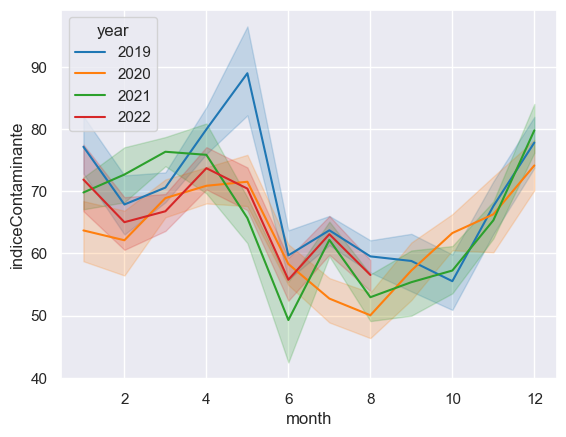

In [35]:
pm25_centro['month'] = pd.to_datetime(pm25_centro.index).month
pm25_centro['year'] = pd.to_datetime(pm25_centro.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm25_centro, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\3260078292.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\3260078292.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



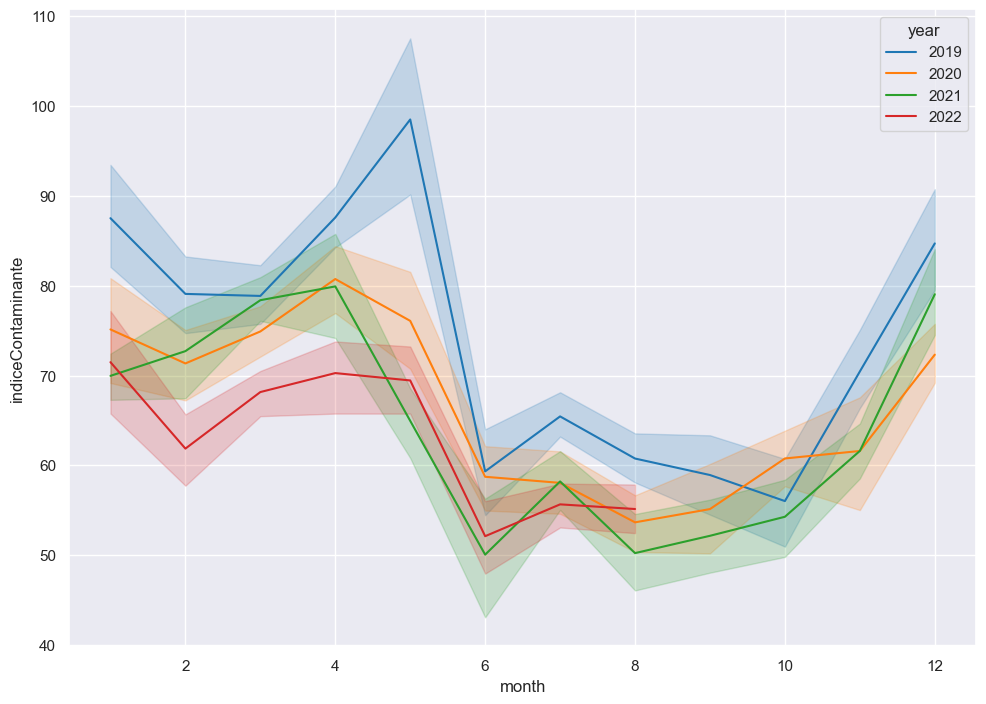

In [36]:
pm25_noreste['month'] = pd.to_datetime(pm25_noreste.index).month
pm25_noreste['year'] = pd.to_datetime(pm25_noreste.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm25_noreste, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\3213607186.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\3213607186.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



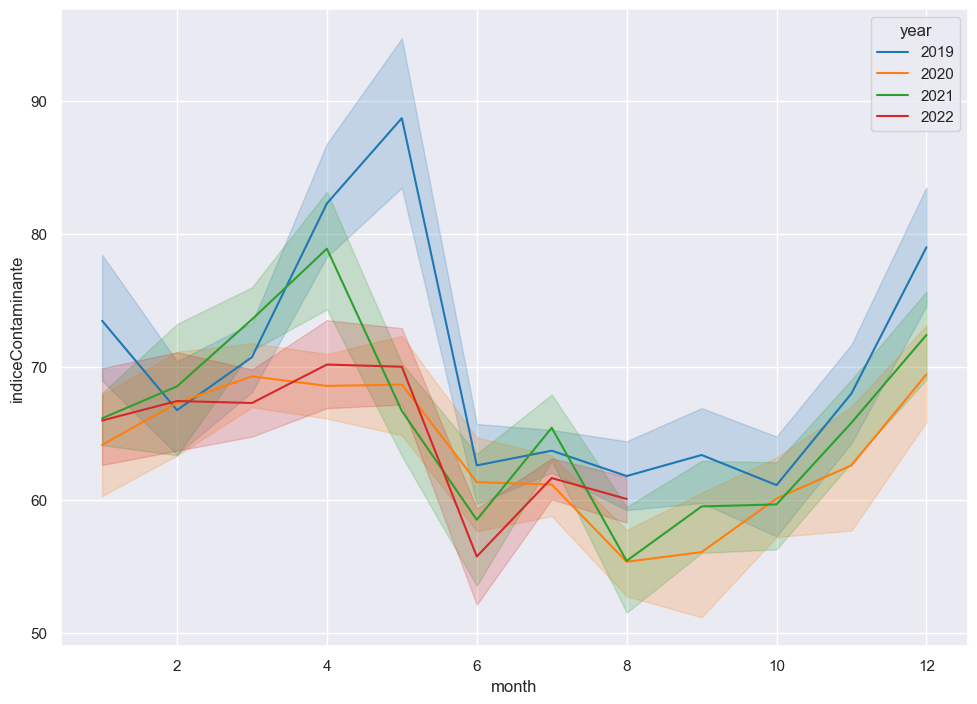

In [37]:
pm25_noroeste['month'] = pd.to_datetime(pm25_noroeste.index).month
pm25_noroeste['year'] = pd.to_datetime(pm25_noroeste.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm25_noroeste, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\2696728183.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\2696728183.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



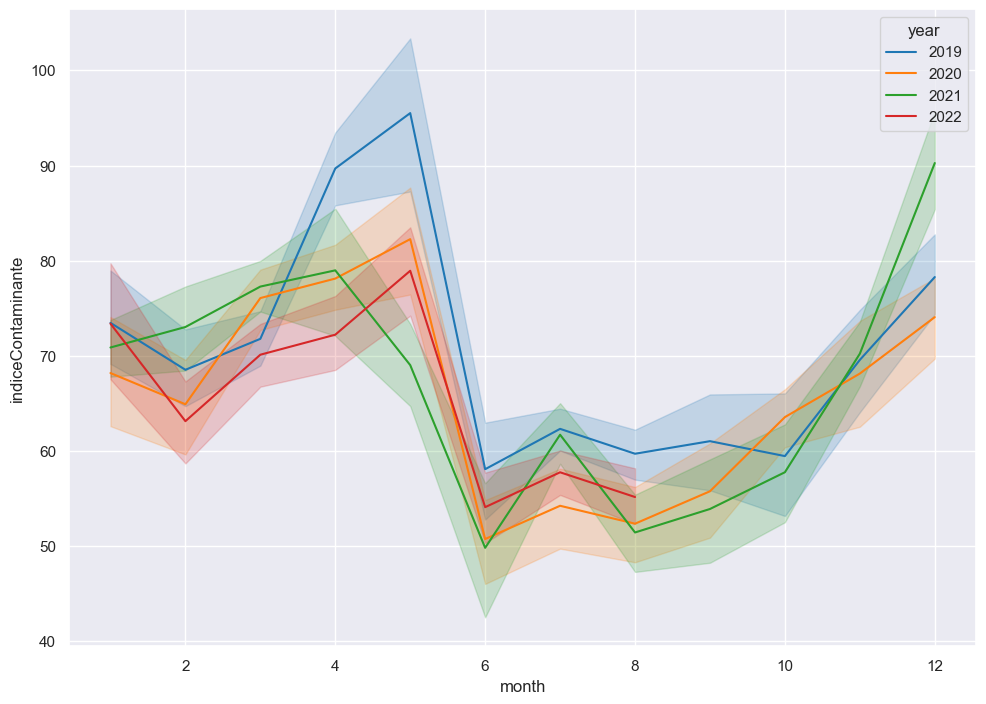

In [38]:
pm25_sureste['month'] = pd.to_datetime(pm25_sureste.index).month
pm25_sureste['year'] = pd.to_datetime(pm25_sureste.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm25_sureste, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1948786454.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1948786454.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



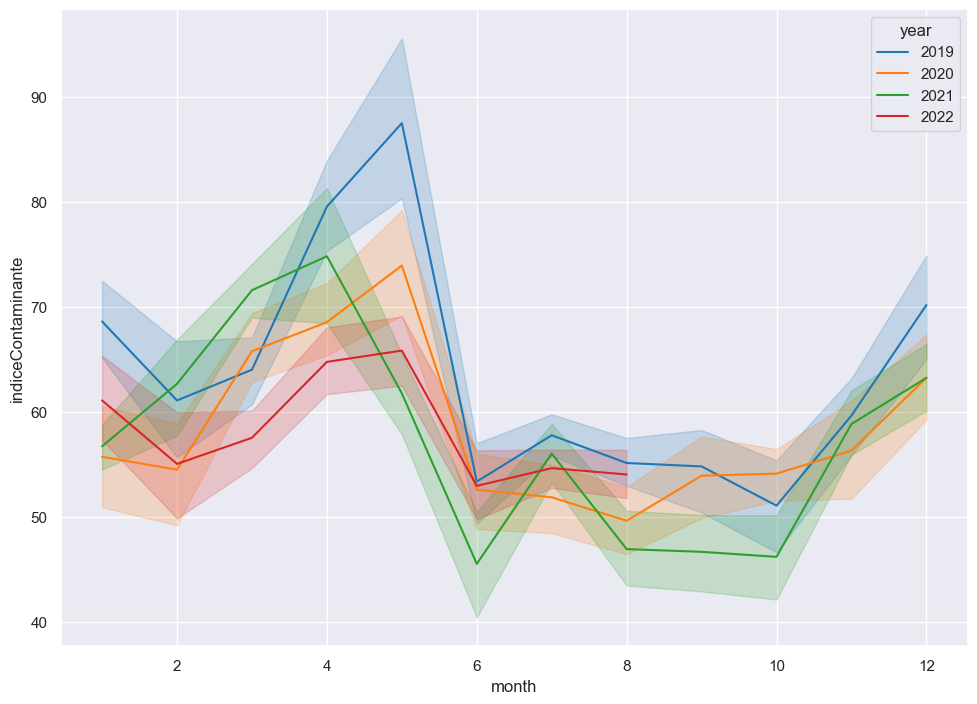

In [39]:
pm25_suroeste['month'] = pd.to_datetime(pm25_suroeste.index).month
pm25_suroeste['year'] = pd.to_datetime(pm25_suroeste.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm25_suroeste, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Graficos de PM10 Por Zona, agrugpando años y meses

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\307279214.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\307279214.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



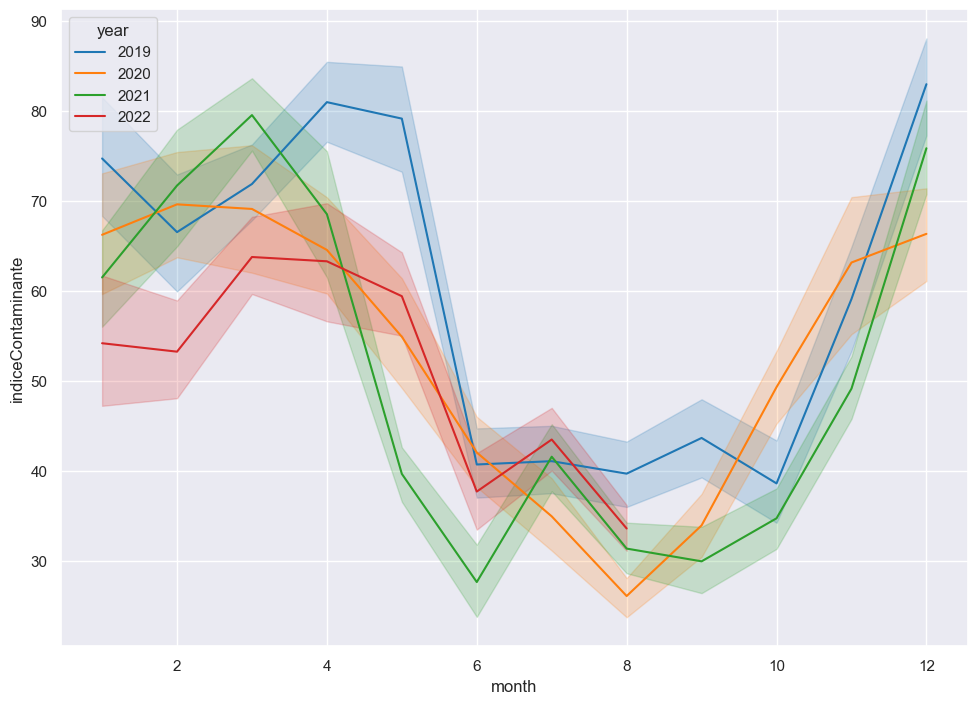

In [40]:
# Centro PM10
pm10_centro['month'] = pd.to_datetime(pm10_centro.index).month
pm10_centro['year'] = pd.to_datetime(pm10_centro.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm10_centro, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})


C:\Users\josev\AppData\Local\Temp\ipykernel_23448\2724494887.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\2724494887.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



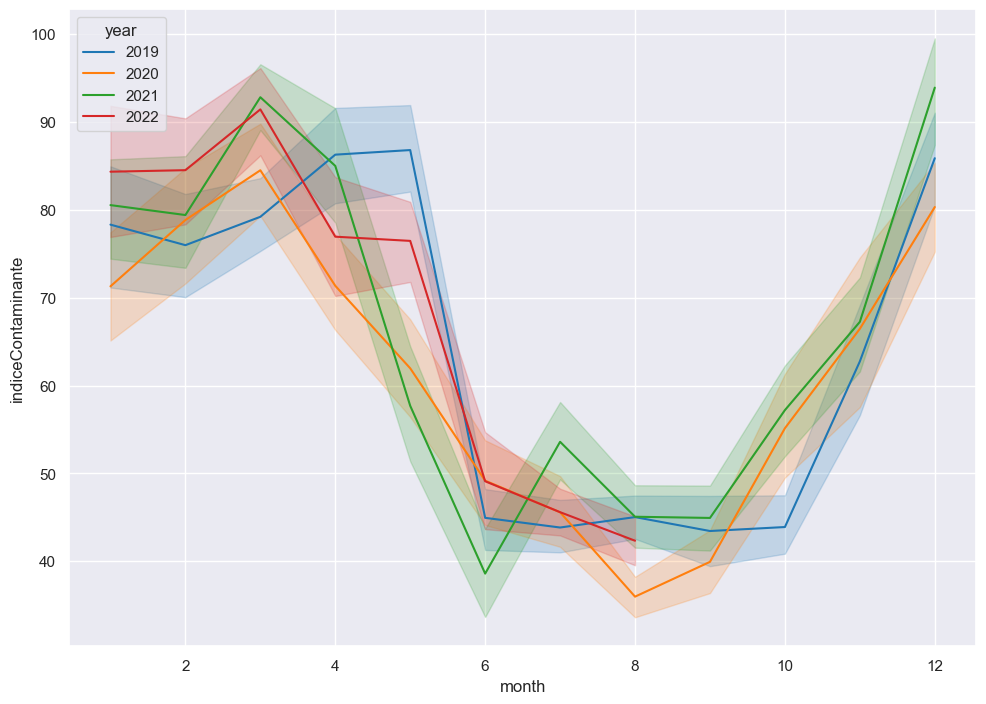

In [41]:
# Noroeste PM10
pm10_noroeste['month'] = pd.to_datetime(pm10_noroeste.index).month
pm10_noroeste['year'] = pd.to_datetime(pm10_noroeste.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm10_noroeste, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1527508122.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1527508122.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



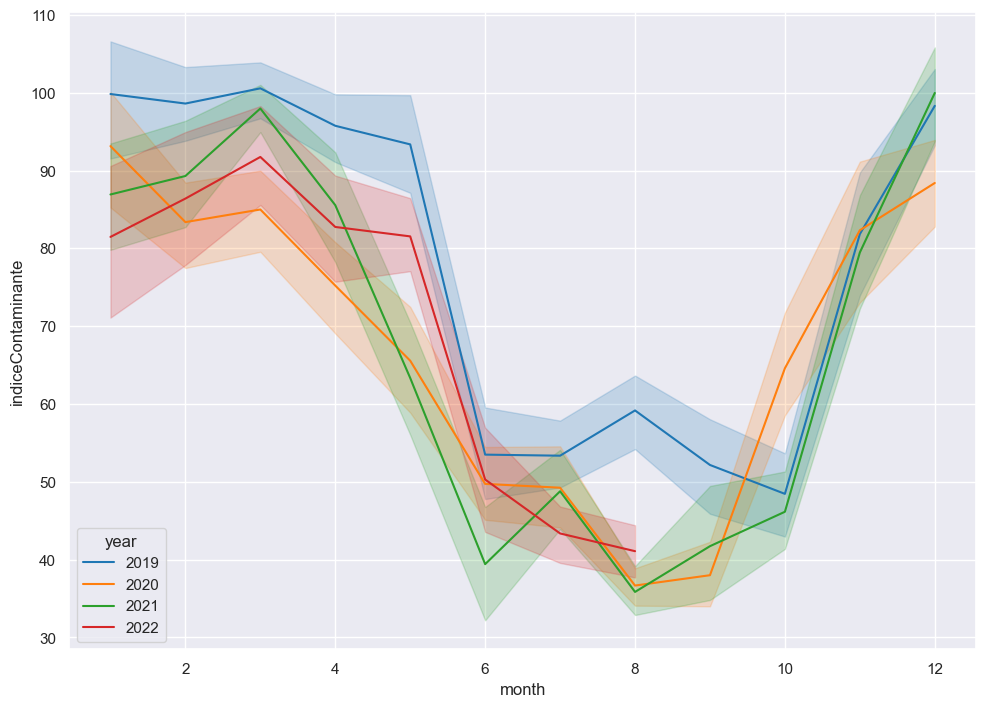

In [42]:
# Noreste PM10
pm10_noreste['month'] = pd.to_datetime(pm10_noreste.index).month
pm10_noreste['year'] = pd.to_datetime(pm10_noreste.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm10_noreste, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1088032690.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\1088032690.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



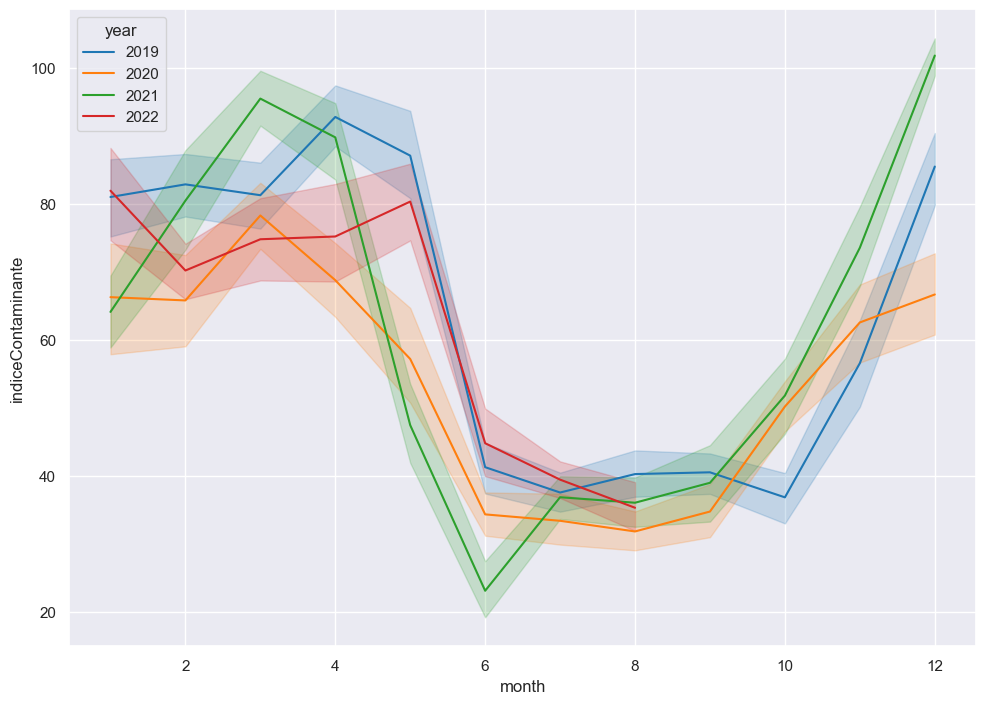

In [43]:
# Sureste PM10
pm10_sureste['month'] = pd.to_datetime(pm10_sureste.index).month
pm10_sureste['year'] = pd.to_datetime(pm10_sureste.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm10_sureste, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})


C:\Users\josev\AppData\Local\Temp\ipykernel_23448\2649661025.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\josev\AppData\Local\Temp\ipykernel_23448\2649661025.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



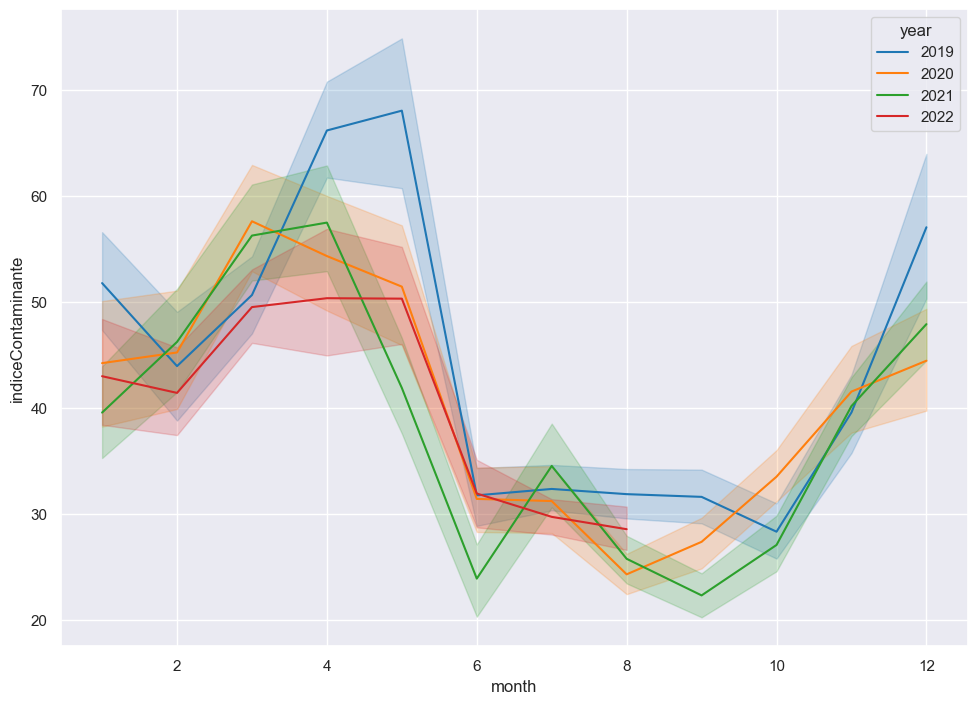

In [44]:
# Suroeste PM10
pm10_suroeste['month'] = pd.to_datetime(pm10_suroeste.index).month
pm10_suroeste['year'] = pd.to_datetime(pm10_suroeste.index).year
sns.lineplot(x='month', y='indiceContaminante', hue='year', data=pm10_suroeste, palette='tab10')
sns.set(rc={'figure.figsize':(11.7,8.27)})


In [45]:
# Definiendo los datos para entrenamiento y prueba (80% Training, 19% Prueba y 1% Real Testing)

# PM25
# Centro
pm25_centro_train = pm25_centro[:int(2/3*pm25_centro.shape[0])]
pm25_centro_test = pm25_centro[:int(2/3*pm25_centro.shape[0]+1):]

# Noroeste
pm25_noroeste_train = pm25_noroeste.iloc[:int(pm25_noroeste.shape[0]*0.8)]
pm25_noroeste_test = pm25_noroeste.iloc[int(pm25_noroeste.shape[0]*0.8):int(pm25_noroeste.shape[0]*0.99)]
pm25_noroeste_real_test = pm25_noroeste.iloc[int(pm25_noroeste.shape[0]*0.99):]

# Noreste
pm25_noreste_train = pm25_noreste.iloc[:int(pm25_noreste.shape[0]*0.8)]
pm25_noreste_test = pm25_noreste.iloc[int(pm25_noreste.shape[0]*0.8):int(pm25_noreste.shape[0]*0.99)]
pm25_noreste_real_test = pm25_noreste.iloc[int(pm25_noreste.shape[0]*0.99):]

# Sureste
pm25_sureste_train = pm25_sureste.iloc[:int(pm25_sureste.shape[0]*0.8)]
pm25_sureste_test = pm25_sureste.iloc[int(pm25_sureste.shape[0]*0.8):int(pm25_sureste.shape[0]*0.99)]
pm25_sureste_real_test = pm25_sureste.iloc[int(pm25_sureste.shape[0]*0.99):]

# Suroeste
pm25_suroeste_train = pm25_suroeste.iloc[:int(pm25_suroeste.shape[0]*0.8)]
pm25_suroeste_test = pm25_suroeste.iloc[int(pm25_suroeste.shape[0]*0.8):int(pm25_suroeste.shape[0]*0.99)]
pm25_suroeste_real_test = pm25_suroeste.iloc[int(pm25_suroeste.shape[0]*0.99):]

# PM10
# Centro
pm10_centro_train = pm10_centro.iloc[:int(pm10_centro.shape[0]*0.8)]
pm10_centro_test = pm10_centro.iloc[int(pm10_centro.shape[0]*0.8):int(pm10_centro.shape[0]*0.99)]
pm10_centro_real_test = pm10_centro.iloc[int(pm10_centro.shape[0]*0.99):]

# Noroeste
pm10_noroeste_train = pm10_noroeste.iloc[:int(pm10_noroeste.shape[0]*0.8)]
pm10_noroeste_test = pm10_noroeste.iloc[int(pm10_noroeste.shape[0]*0.8):int(pm10_noroeste.shape[0]*0.99)]
pm10_noroeste_real_test = pm10_noroeste.iloc[int(pm10_noroeste.shape[0]*0.99):]

# Noreste
pm10_noreste_train = pm10_noreste.iloc[:int(pm10_noreste.shape[0]*0.8)]
pm10_noreste_test = pm10_noreste.iloc[int(pm10_noreste.shape[0]*0.8):int(pm10_noreste.shape[0]*0.99)]
pm10_noreste_real_test = pm10_noreste.iloc[int(pm10_noreste.shape[0]*0.99):]

# Sureste
pm10_sureste_train = pm10_sureste.iloc[:int(pm10_sureste.shape[0]*0.8)]
pm10_sureste_test = pm10_sureste.iloc[int(pm10_sureste.shape[0]*0.8):int(pm10_sureste.shape[0]*0.99)]
pm10_sureste_real_test = pm10_sureste.iloc[int(pm10_sureste.shape[0]*0.99):]

# Suroeste
pm10_suroeste_train = pm10_suroeste.iloc[:int(pm10_suroeste.shape[0]*0.8)]
pm10_suroeste_test = pm10_suroeste.iloc[int(pm10_suroeste.shape[0]*0.8):int(pm10_suroeste.shape[0]*0.99)]
pm10_suroeste_real_test = pm10_suroeste.iloc[int(pm10_suroeste.shape[0]*0.99):]

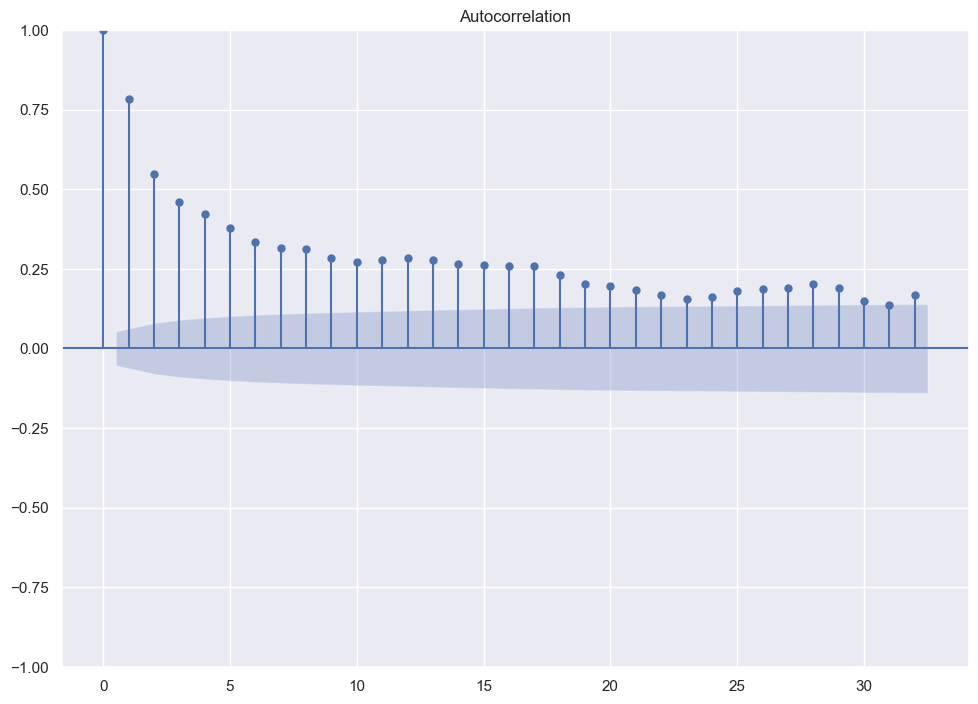

In [46]:
# Autocorrelacion
# PM25
# Centro
plot_acf(pm25_centro.indiceContaminante)
plt.show()

C:\Users\josev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



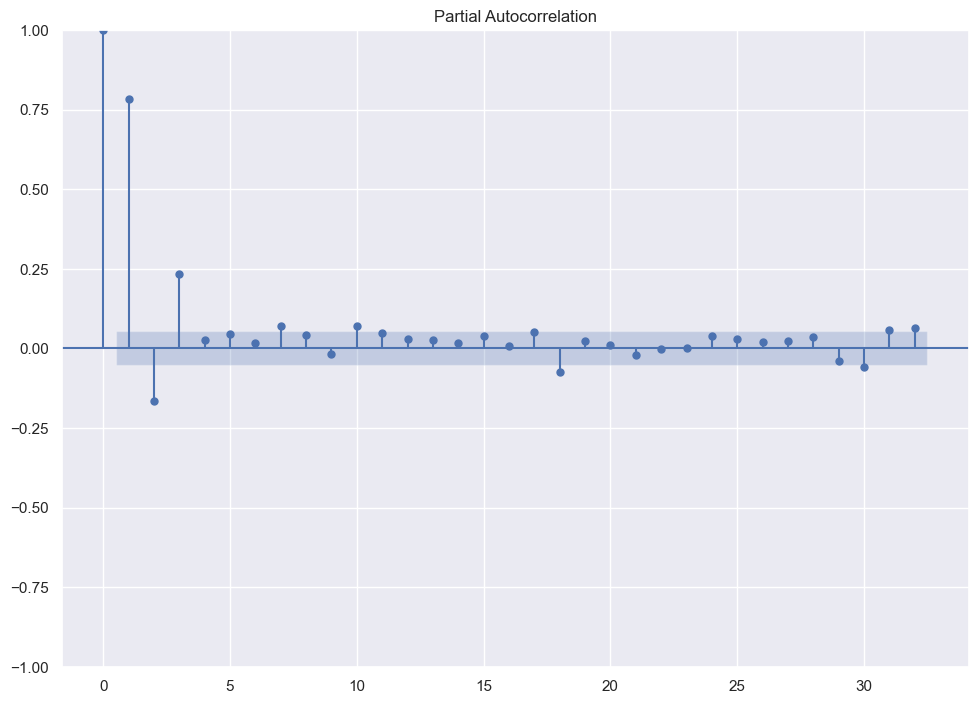

In [47]:
# Parcial Autocorrelacion
# PM25
# Centro
plot_pacf(pm25_centro.indiceContaminante)
plt.show()

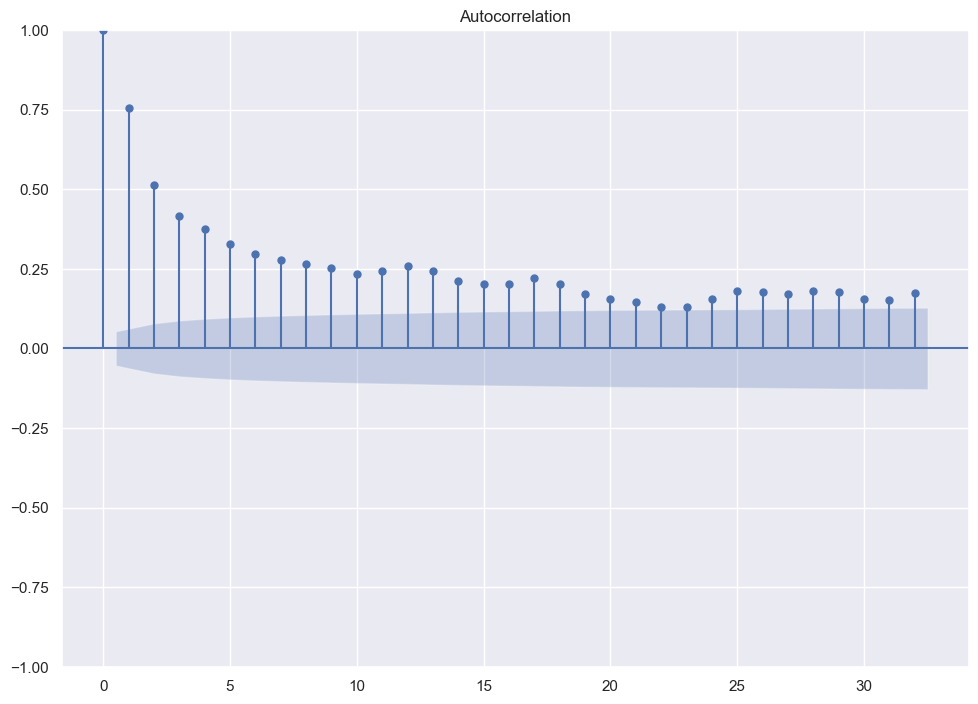

In [48]:
# Autocorrelation
# PM25
# Noroeste

plot_acf(pm25_noroeste.indiceContaminante)
plt.show()

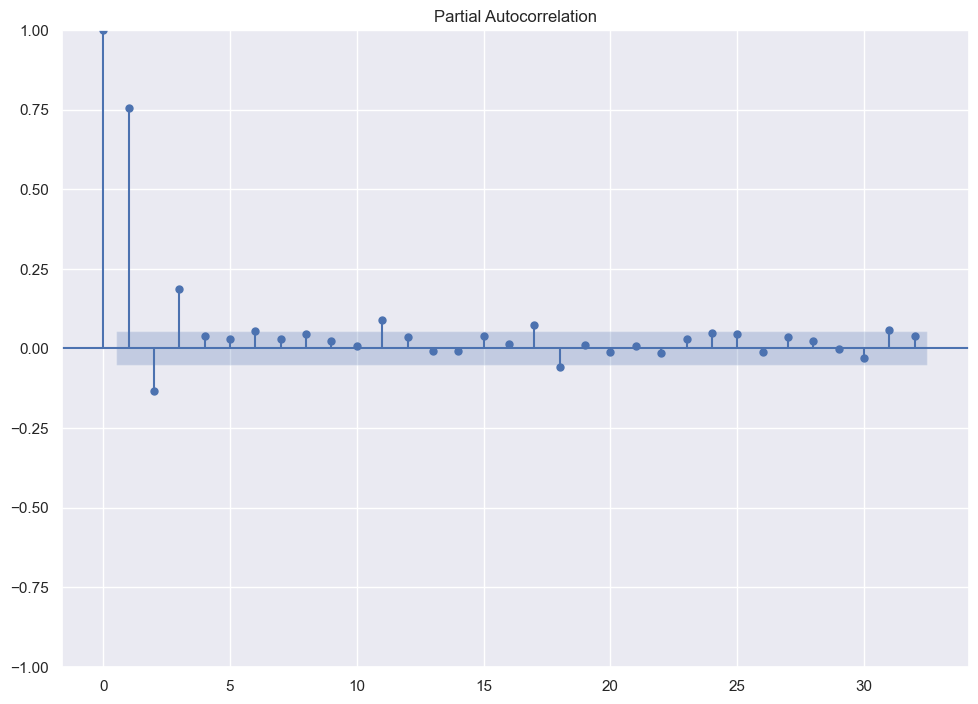

In [49]:
# Parcial Autocorrelation
# PM25
# Noroeste

plot_pacf(pm25_noroeste.indiceContaminante)
plt.show()

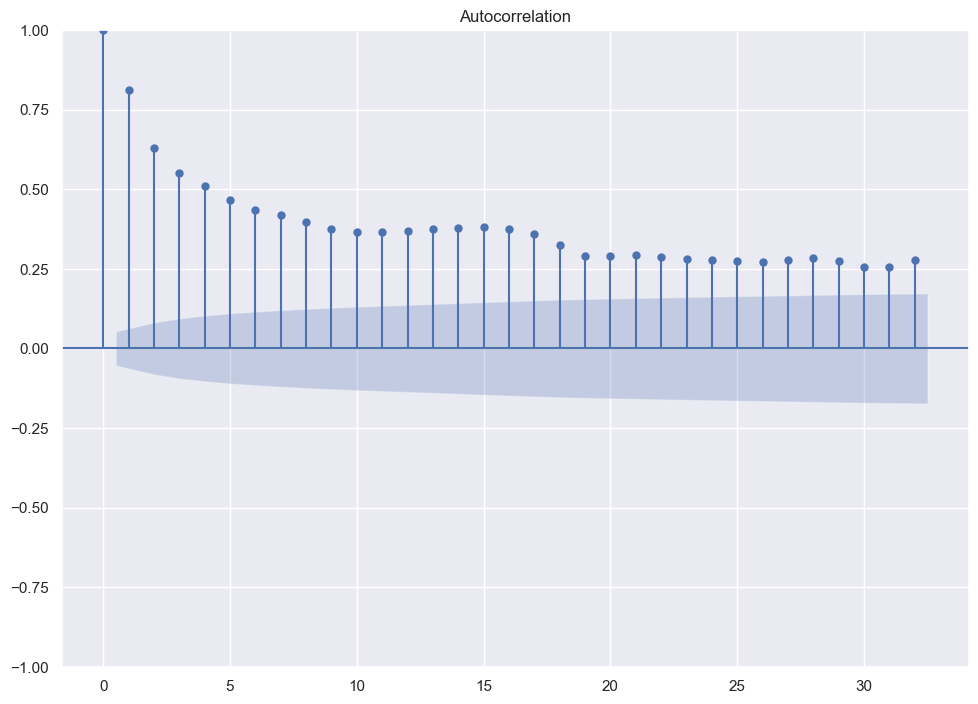

In [50]:
# AutoCorrelation
# PM25
# Noreste

plot_acf(pm25_noreste.indiceContaminante)
plt.show()

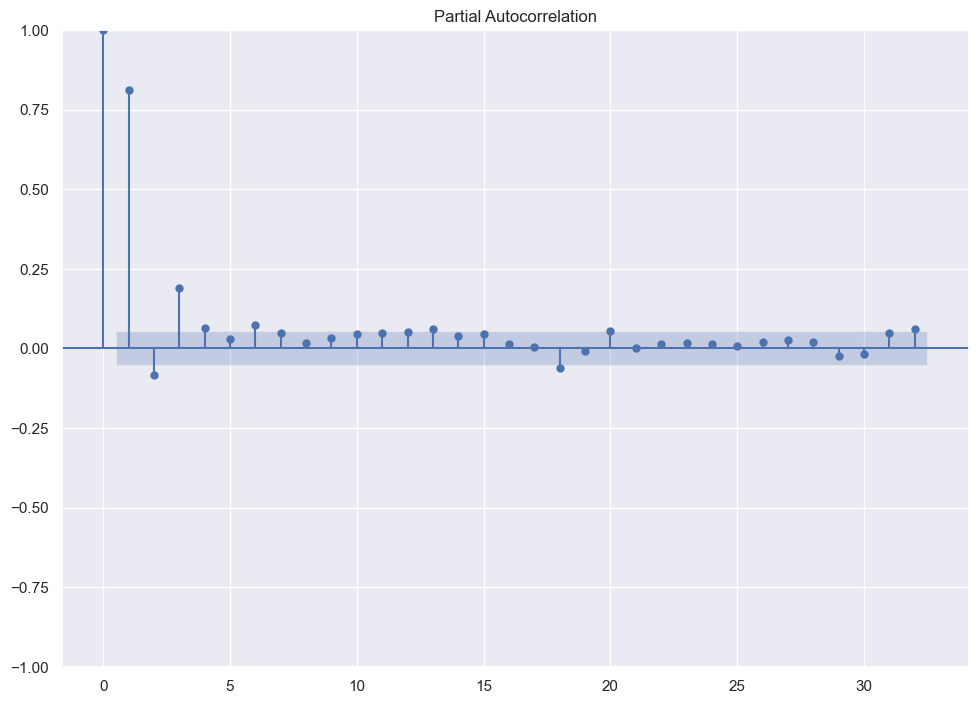

In [51]:
# Parcial Autocorrelation
# PM25
# Noreste

plot_pacf(pm25_noreste.indiceContaminante)
plt.show()

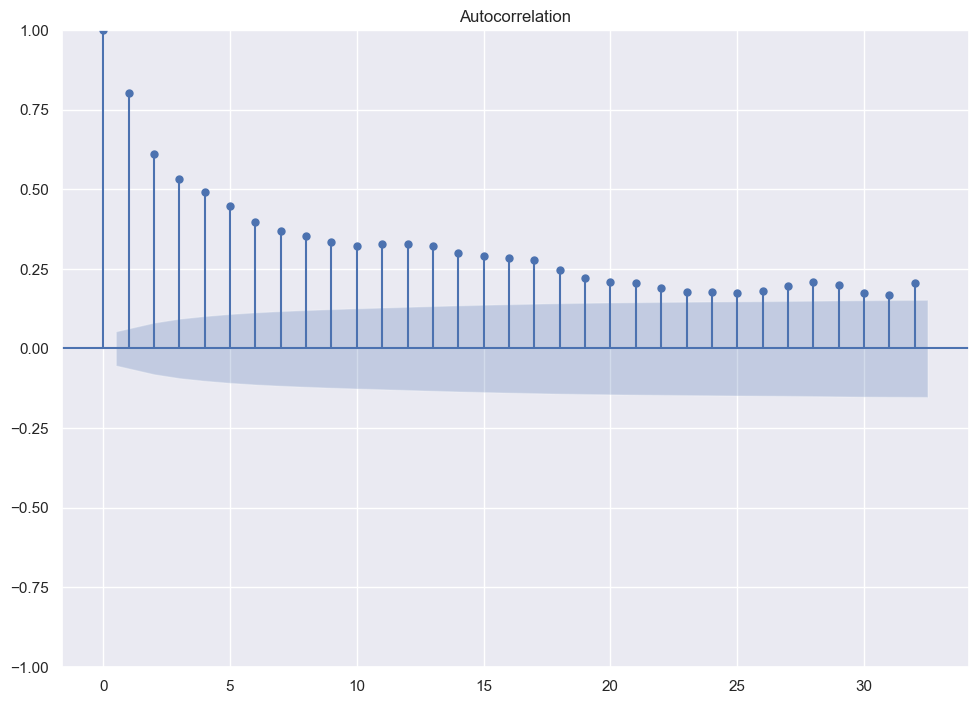

In [52]:
# AutoCorrelation
# PM25
# Sureste

plot_acf(pm25_sureste.indiceContaminante)
plt.show()

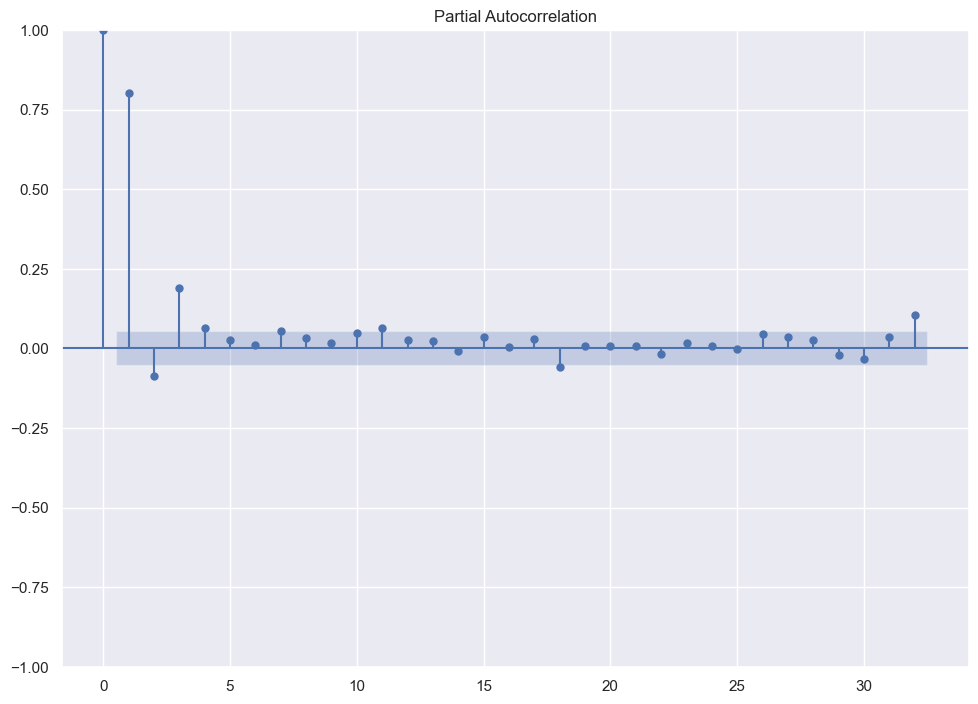

In [53]:
# Parcial Autocorrelation
# PM25
# Sureste

plot_pacf(pm25_sureste.indiceContaminante)
plt.show()

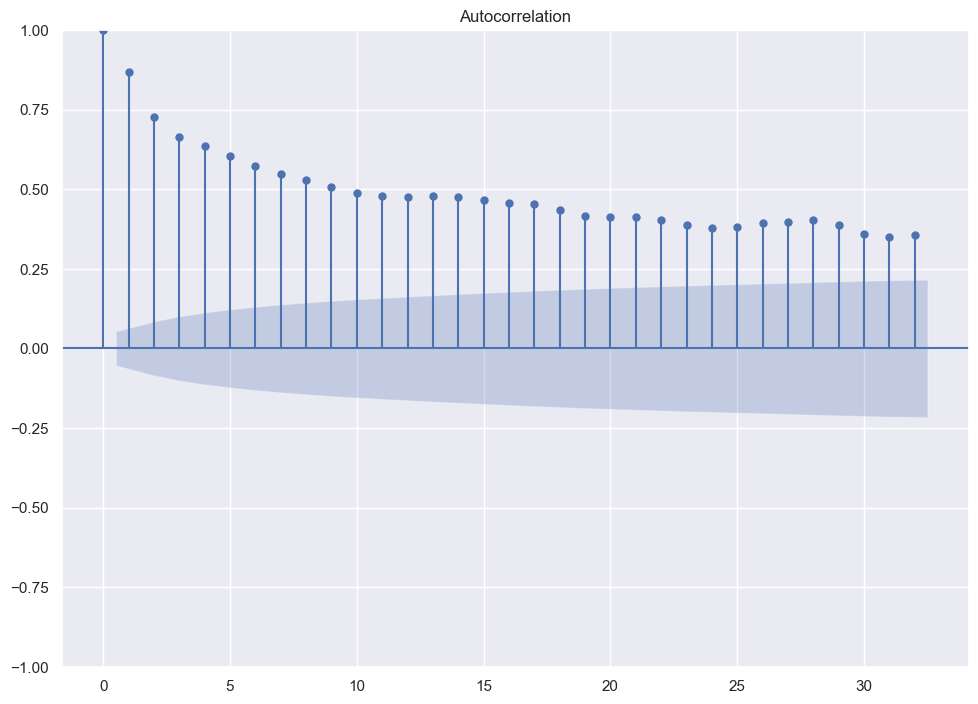

In [54]:
# AutoCorrelation
# PM10
# Centro

plot_acf(pm10_centro.indiceContaminante)
plt.show()

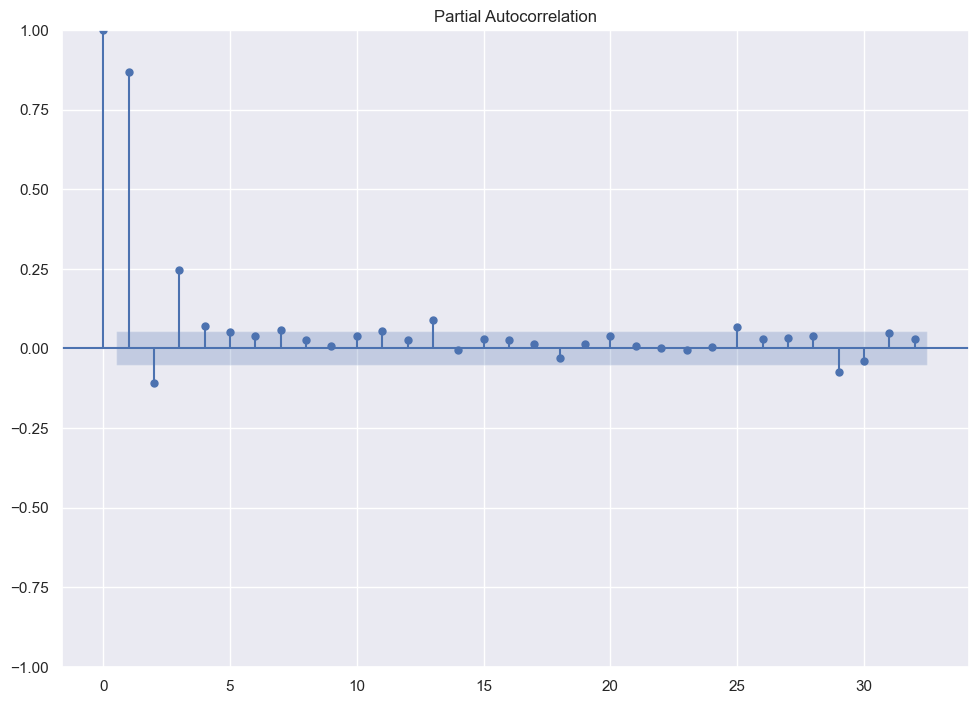

In [55]:
# Parcial Autocorrelation
# PM10
# Centro

plot_pacf(pm10_centro.indiceContaminante)
plt.show()

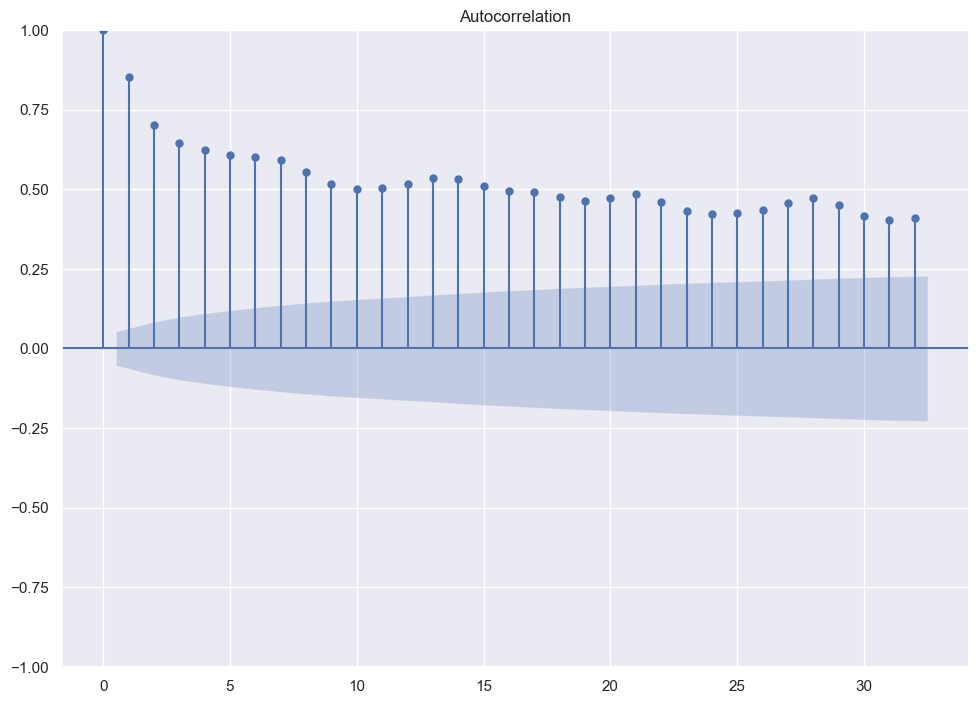

In [56]:
# AutoCorrelation
# PM10
# Noroeste

plot_acf(pm10_noroeste.indiceContaminante)
plt.show()

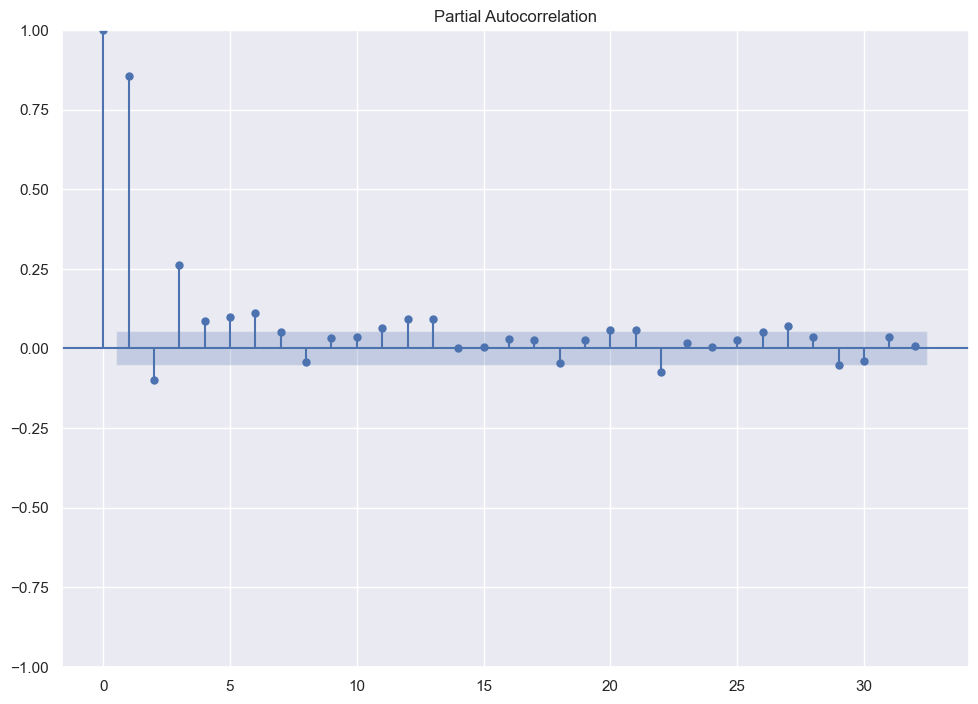

In [57]:
# Parcial Autocorrelation
# PM10
# Noroeste

plot_pacf(pm10_noroeste.indiceContaminante)
plt.show()

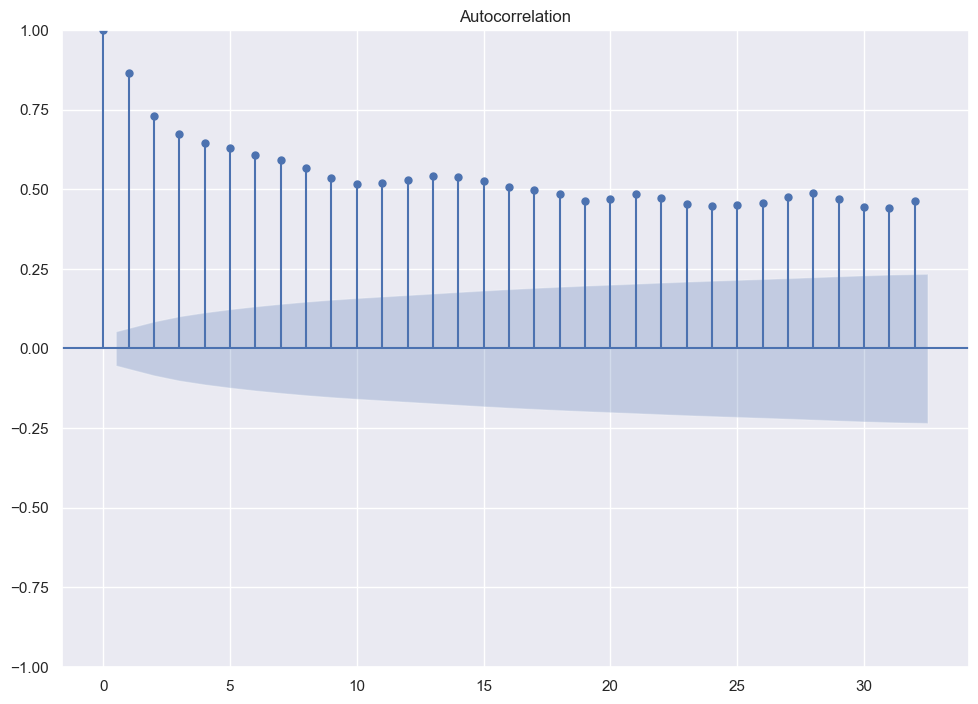

In [58]:
# AutoCorrelation
# PM10
# Noreste

plot_acf(pm10_noreste.indiceContaminante)
plt.show()

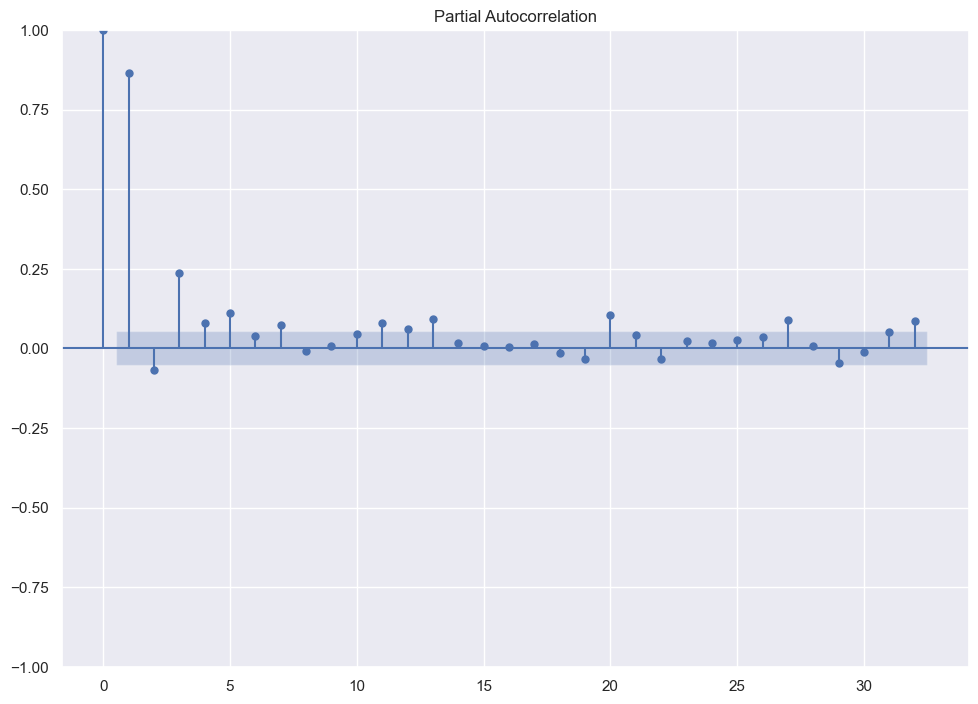

In [59]:
# Parcial Autocorrelation
# PM10
# Noreste

plot_pacf(pm10_noreste.indiceContaminante)
plt.show()

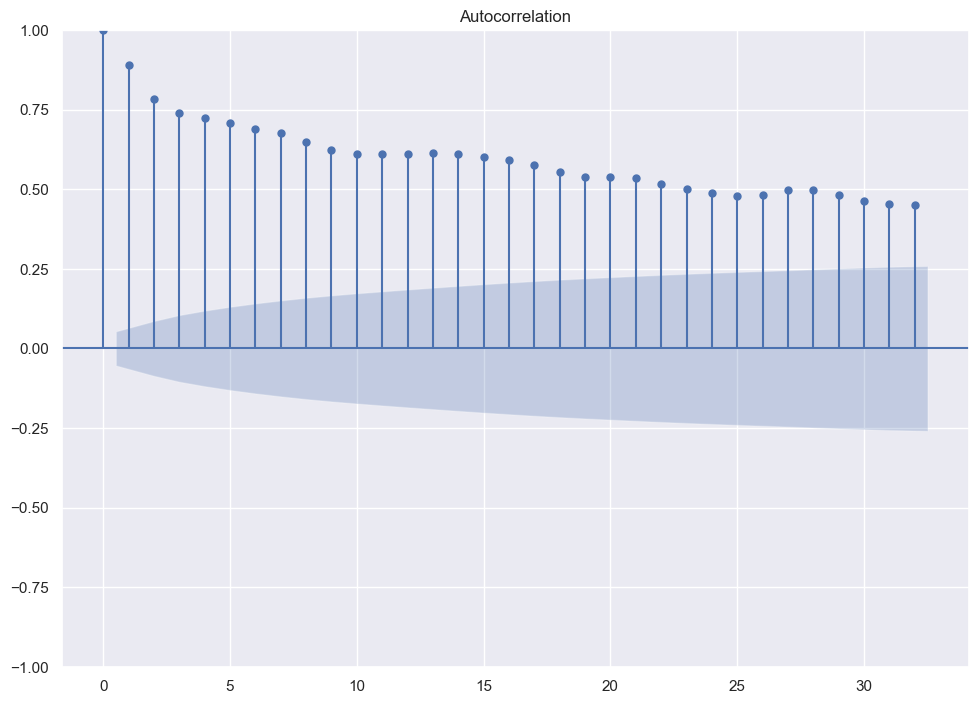

In [60]:
# AutoCorrelation
# PM10
# Sureste

plot_acf(pm10_sureste.indiceContaminante)
plt.show()

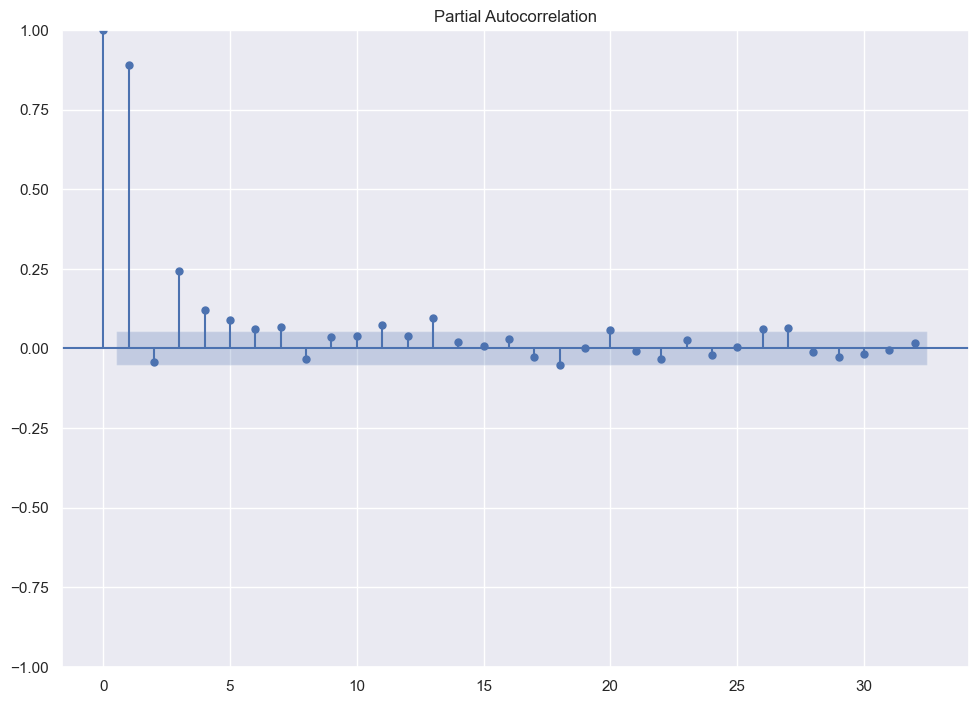

In [61]:
# Parcial Autocorrelation
# PM10
# Sureste

plot_pacf(pm10_sureste.indiceContaminante)
plt.show()

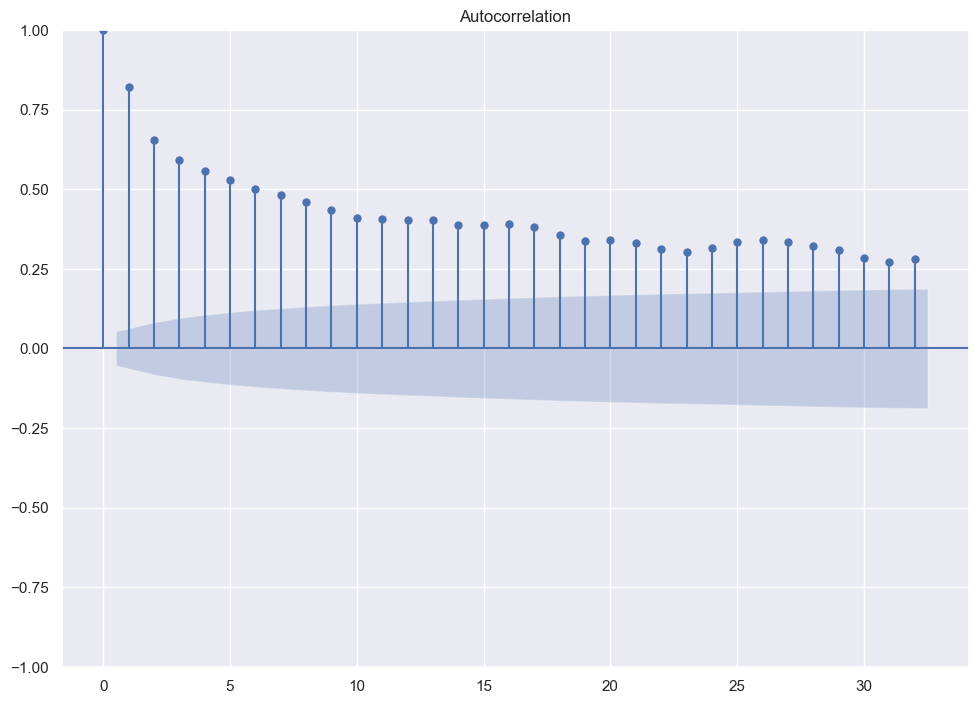

In [62]:
# AutoCorrelation
# PM10
# Suroeste

plot_acf(pm10_suroeste.indiceContaminante)
plt.show()

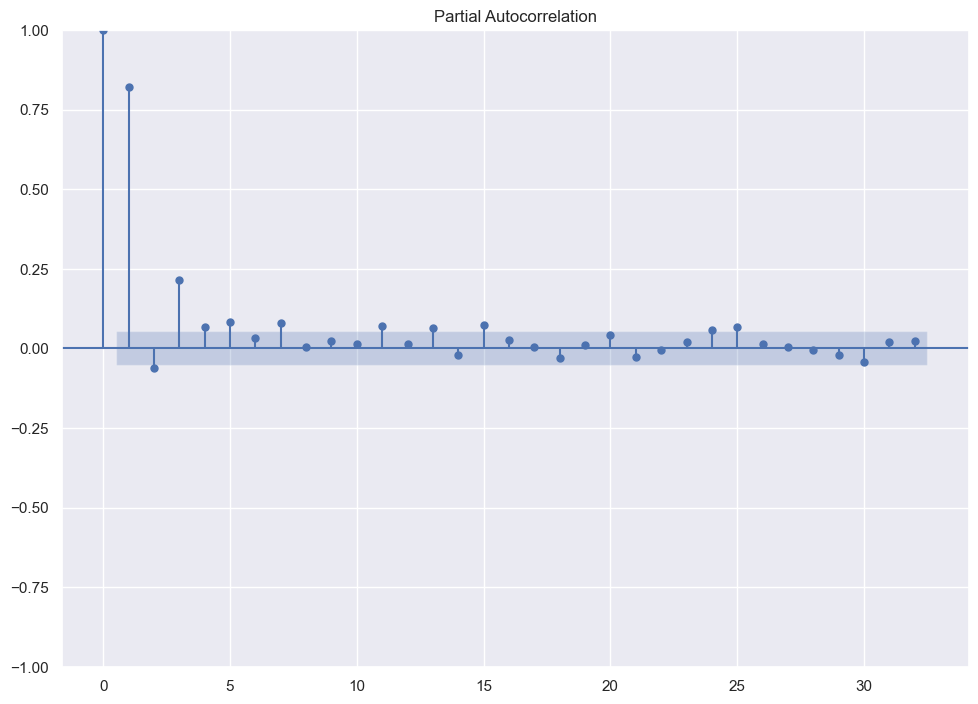

In [63]:
# Parcial Autocorrelation
# PM10
# Suroeste

plot_pacf(pm10_suroeste.indiceContaminante)
plt.show()

C:\Users\josev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



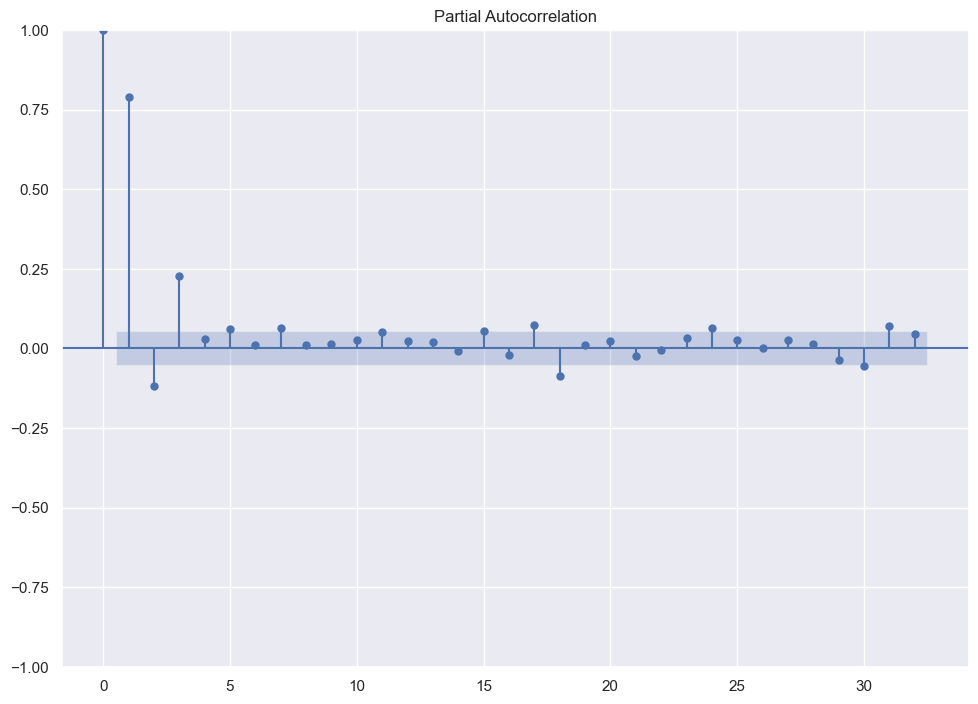

In [82]:
# Partial Autocorrelation
# PM25

plot_pacf(pm25_suroeste.indiceContaminante)
plt.show()

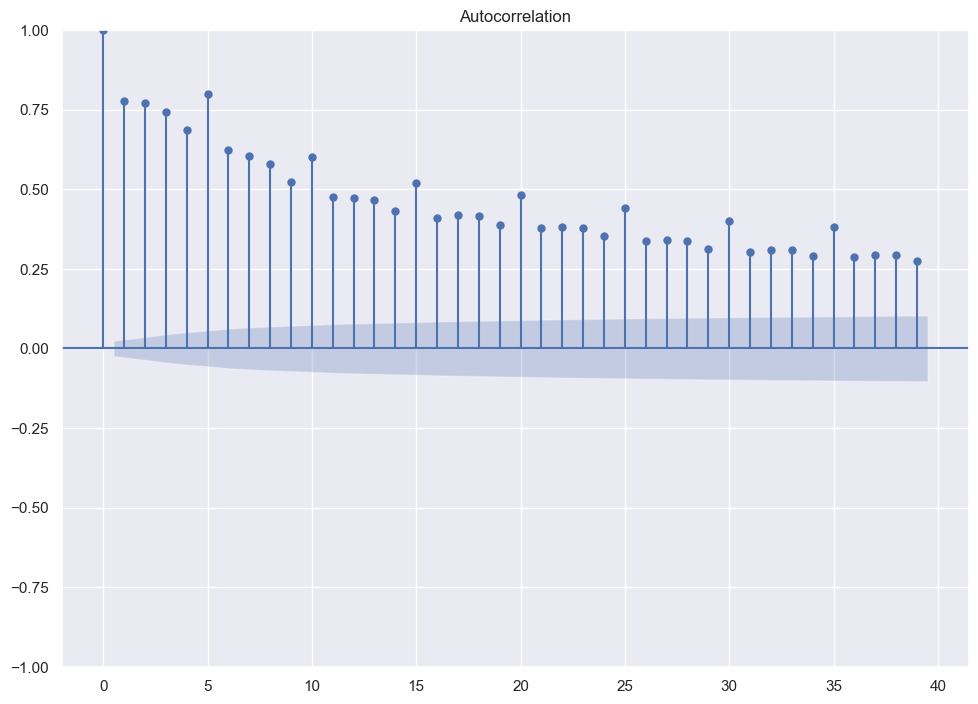

In [83]:
# Autocorrelation
# PM25

plot_acf(pm25.indiceContaminante)
plt.show()

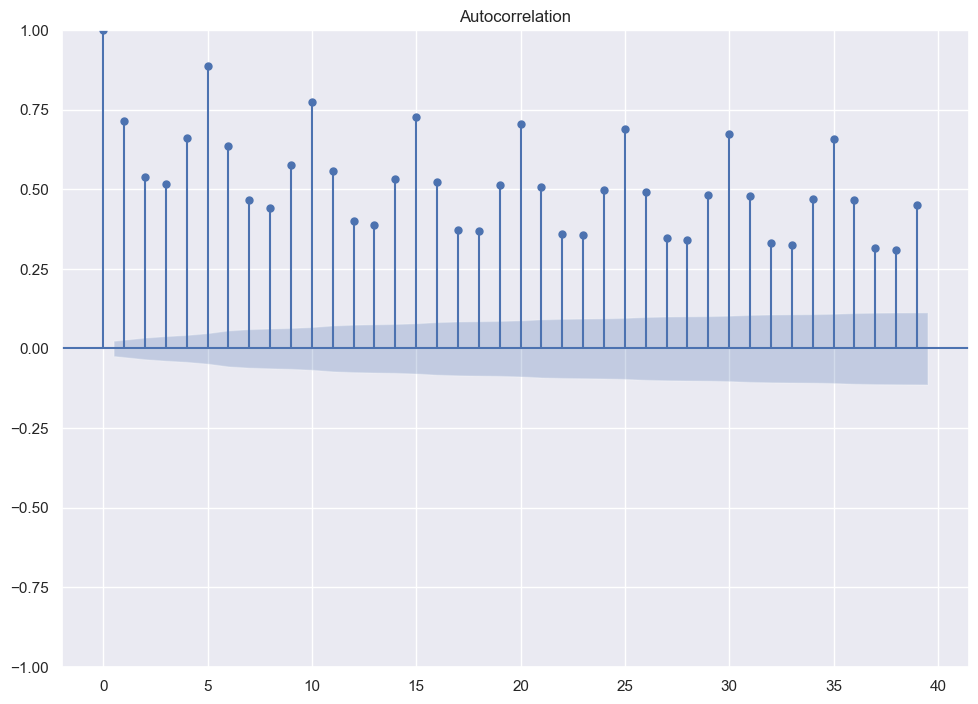

In [84]:
# Autocorrelation
# PM10

plot_acf(pm10.indiceContaminante)
plt.show()

C:\Users\josev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Dickey-Fuller criterion: p=0.000006


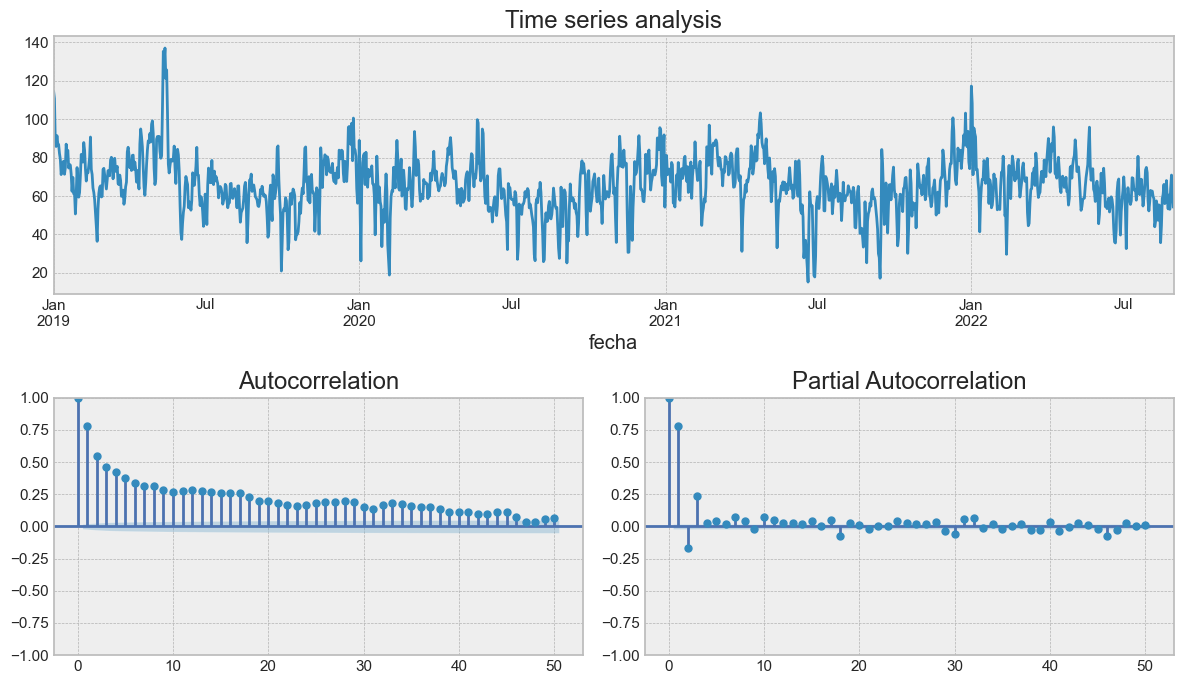

In [64]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time series analysis')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(pm25_centro.indiceContaminante, lags=50)

# Forecasting - Predicción

Pronosticaremos haciendo SARIMA

In [65]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error as mapeee
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

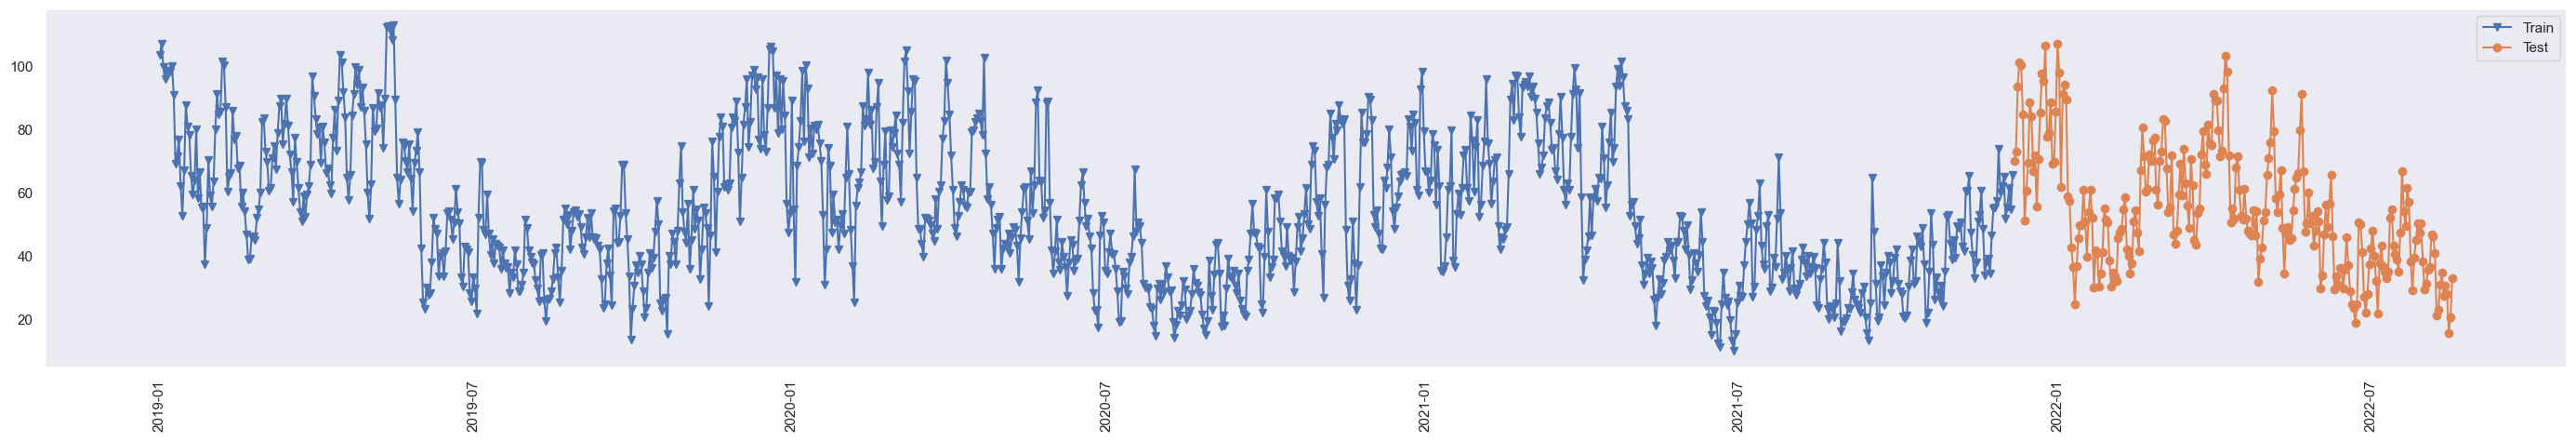

In [66]:
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(pm10_centro_train['indiceContaminante'], marker='v', label='Train')
plt.plot( pm10_centro_test['indiceContaminante'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [67]:
# Modelo SARIMAX

<AxesSubplot: xlabel='fecha'>

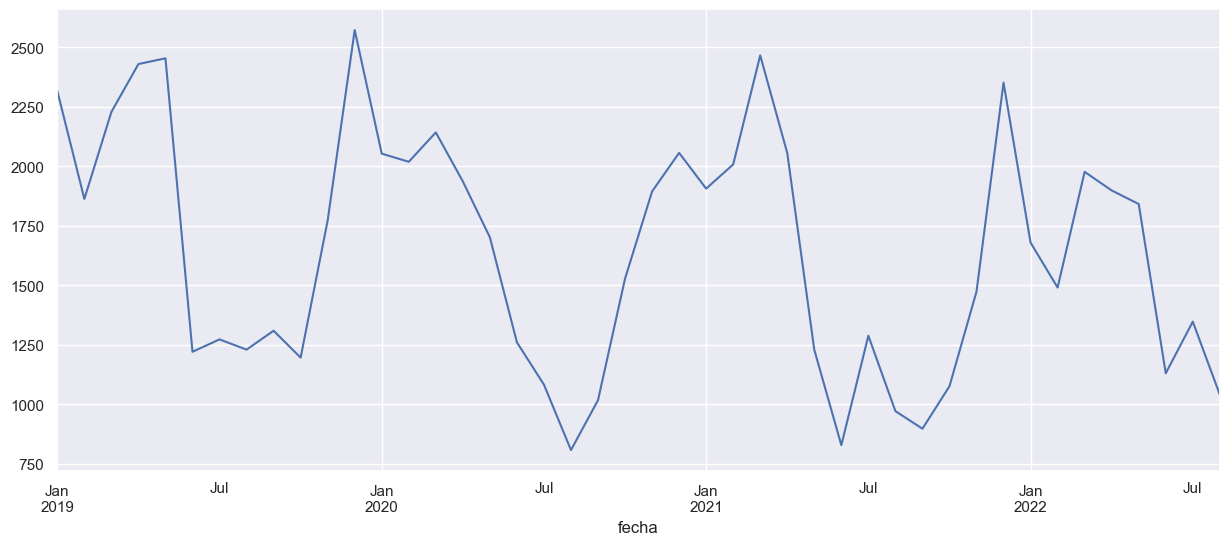

In [68]:
pm10_centro.indiceContaminante.resample('M').sum().plot(figsize=(15, 6))

## Estacionalidad de 6 meses

In [126]:
# Definiendo dos tercios de los datos para entrenamiento y un tercio para prueba:

# PM10 noreste train
pm10_centro_train = pm10_centro.iloc[:int(pm10_centro.shape[0]*0.8)]
# PM10 noreste test
pm10_centro_test = pm10_centro.iloc[int(pm10_centro.shape[0]*0.8):]

# PM10 noroeste train
pm10_noroeste_train = pm10_noroeste.iloc[:int(pm10_noroeste.shape[0]*0.8)]
# PM10 noroeste test
pm10_noroeste_test = pm10_noroeste.iloc[int(pm10_noroeste.shape[0]*0.8):]

# PM25 noreste train
pm25_noreste_train = pm25_noreste.iloc[:int(pm25_noreste.shape[0]*0.8)]
# PM25 noreste test
pm25_noreste_test = pm25_noreste.iloc[int(pm25_noreste.shape[0]*0.8):]

# PM25 noroeste train
pm25_noroeste_train = pm25_noroeste.iloc[:int(pm25_noroeste.shape[0]*0.8)]
# PM25 noroeste test
pm25_noroeste_test = pm25_noroeste.iloc[int(pm25_noroeste.shape[0]*0.8):]

In [127]:
# Librerias base
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

# Librerias de statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [140]:
arima_1_auto = ARIMA(pm10_noreste_train.indiceContaminante, order=([5,7,22], 1, 1)).fit()

C:\Users\josev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\josev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\josev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [141]:
arima_1_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:          indiceContaminante   No. Observations:                 1071
Model:             ARIMA([5, 7, 22], 1, 1)   Log Likelihood               -4358.544
Date:                     Wed, 18 Jan 2023   AIC                           8727.089
Time:                             22:58:38   BIC                           8751.966
Sample:                         01-01-2019   HQIC                          8736.513
                              - 12-06-2021                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L5          0.0088      0.030      0.297      0.766      -0.050       0.067
ar.L7          0.0112      0.028      0.407      0.684      -0.043       0.065
ar.L22         0.0005      0.033      0.014      0.989      -0.064       0.065
ma.L1         -0.0058      0.024     -0.235      0.814      -0.054       0.042
sigma2       202.1342      7.110     28.430      0.000     188.199     216.069
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                58.41
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.02
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [142]:
# Predicciones del propio conjunto de datos de entrenamiento:
arima_1_auto.predict(typ='levels')
#Donde "type='levels'" corrige los valores pronosticados "invirtiendo" la diferenciación

2019-01-01      0.000000
2019-01-02    148.124828
2019-01-03    116.516239
2019-01-04    114.218447
2019-01-05    117.895150
                 ...    
2021-12-02    111.172791
2021-12-03    108.364839
2021-12-04    102.701253
2021-12-05     93.872489
2021-12-06     77.242692
Freq: D, Name: predicted_mean, Length: 1071, dtype: float64

<AxesSubplot: xlabel='fecha'>

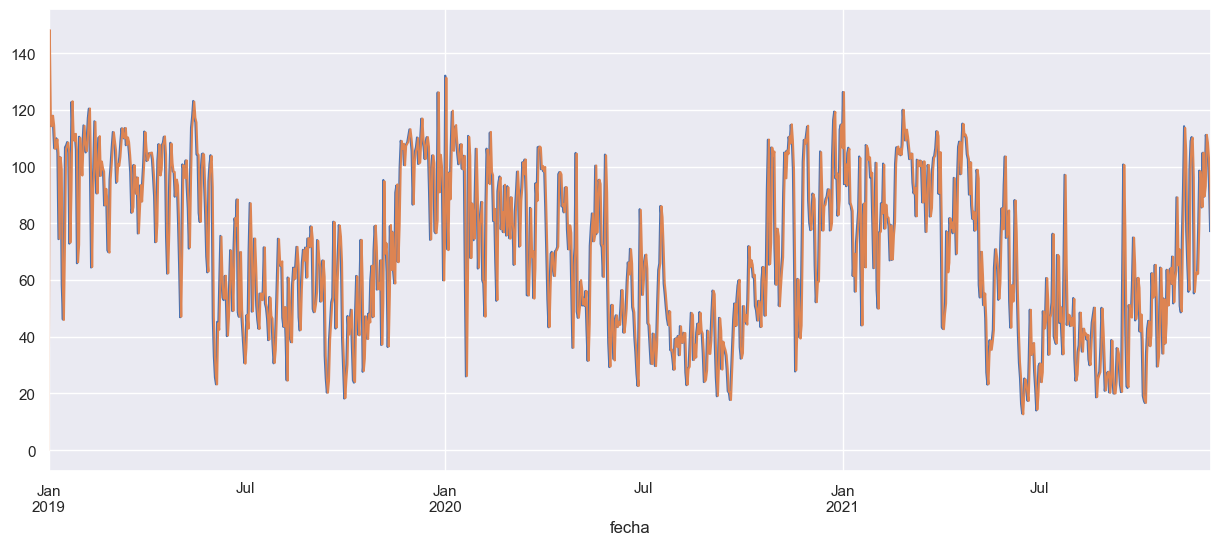

In [143]:
#Comparando modelo con datos reales:
pm10_noreste_train["indiceContaminante"].plot(figsize=(15,6))
arima_1_auto.predict(typ='levels').plot(figsize=(15,6))


In [114]:
# Predicciones para el conjunto de datos de prueba:
prediccion_arima_1_auto=arima_1_auto.predict(start=pm10_noreste_train.shape[0]+1, end=pm10_noreste_train.shape[0]+pm10_noreste_test.shape[0], typ='levels')
prediccion_arima_1_auto.index=pm10_noreste_test.index
prediccion_arima_1_auto

fecha
2021-12-07    84.453383
2021-12-08    83.862898
2021-12-09    83.769729
2021-12-10    83.554988
2021-12-11    84.015591
                ...    
2022-08-13    84.115381
2022-08-14    84.115381
2022-08-15    84.115381
2022-08-16    84.115381
2022-08-17    84.115381
Name: predicted_mean, Length: 254, dtype: float64

<AxesSubplot: xlabel='fecha'>

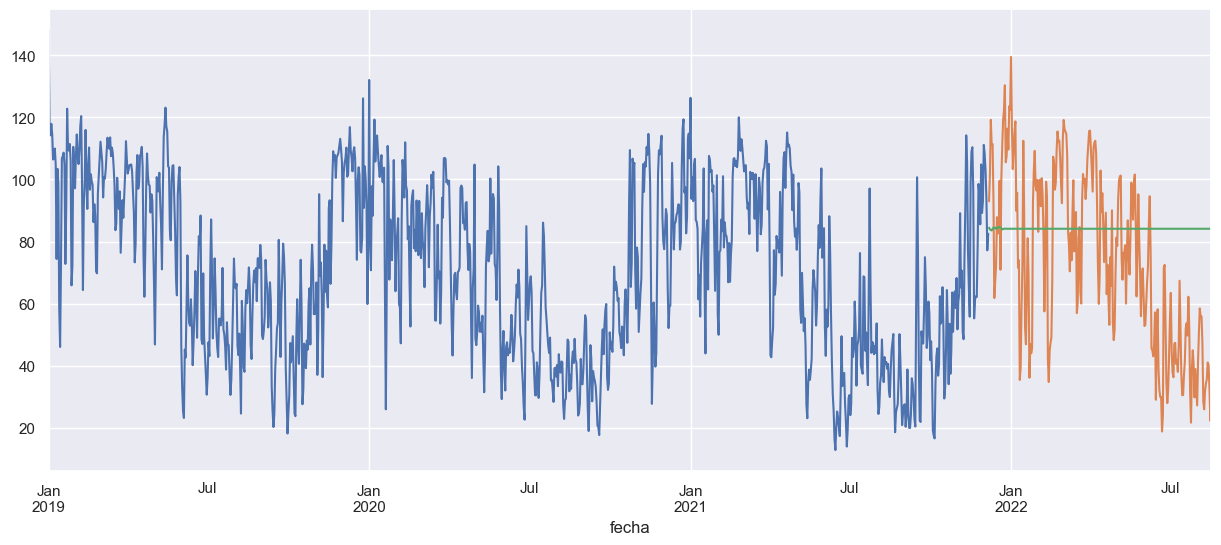

In [117]:
# Visualizando las predicciones
pm10_noreste_train["indiceContaminante"].plot(figsize=(15,6))
pm10_noreste_test["indiceContaminante"].plot(figsize=(15,6))
prediccion_arima_1_auto.plot(figsize=(15,6))

In [76]:
# Juntar todos los dias iguales y hacer promedio

pm10_centro_train

,tipoContaminante,nombreZona,idContaminacion,indiceContaminante,idTipoContaminante,idZona,idTiempo,esNulo,indiceContaminante_nulos,month,year
fecha,,,,,,,,,,,
2019-01-01,PM10,Centro,361.0,103.666667,26.75,2.0,11.5,0.0,0.0,1,2019
2019-01-02,PM10,Centro,1081.0,107.125000,28.00,2.0,35.5,0.0,0.0,1,2019
2019-01-03,PM10,Centro,1801.0,99.666667,24.50,2.0,59.5,0.0,0.0,1,2019
2019-01-04,PM10,Centro,2521.0,95.875000,22.75,2.0,83.5,0.0,0.0,1,2019
2019-01-05,PM10,Centro,3241.0,98.666667,25.00,2.0,107.5,0.0,0.0,1,2019
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-02,PM10,Centro,767881.0,51.875000,18.75,2.0,25595.5,0.0,0.0,12,2021
2021-12-03,PM10,Centro,768601.0,55.458333,20.75,2.0,25619.5,0.0,0.0,12,2021
2021-12-04,PM10,Centro,769321.0,61.541667,22.00,2.0,25643.5,0.0,0.0,12,2021
